## Multi-Epoch Spectral Fitting (MESFit)

### MESFit is a code to perform the spectral decomposition of AGN in time-series analysis. 

Here we give an example of 50-epoch SDSS-RM quasar to extract the information from the time series spectroscopies. The information including the Mean (RMS) spectrum, continuum (emission line) light curves, host stellar velocity dispersion, radial velocity shift of broad emission lines,  and some basic continuum and line properties obtained from QSOFit. 

#### Main procedures:
#### 1) Coadd spectrum 
Convert the spectra to rest-frame and coadd the spectra to get the mean and rms spectrum. Note that the rms spectrum is the total flux rms spectrum, we will produce the emission line only rms spectrum in the last step.

#### 2) Calibration 
Calibration with narrow lines (e.g., [OIII]) assuming the narrow line flux is constant during the monitoring. Normalized the multi-epoch spectra with **A * (GaussFilter(flux, sigma) + yshift)** , where A is the scale factor, sigma is the width of the Gaussian Filter to cancel the effects of different seeings and slits, and yshift is the continuum variability around the narrow line. We did not use any redshift corrections since the most time, they are unnecessary. 

#### 3) Decompose mean spectrum
Fit the mean spectrum with QSOFit to obtain the host galaxy component, and narrow lines since these two components are usually constant. 

#### 4) Fit the host with pPXF
Use pPXF to fit the host component to get the stellar velocity dispersion (or properties of the stellar population and star-formation history).

#### 5) Decompose nightly spectrum
Subtract the same host component from the nightly spectrum to perform the spectral decomposition with fixed all narrow emission line profiles. Save the fitting results to MESFit_results.fits

#### 6) Exhibit the results
With the MESFit results, we can 1) check the continuum and line light curves, 2) investigate the relations among $L_{\rm con}$, $L_{\rm line}$, EW, FWHM, $\sigma$, line peak. 3) check the radial velocity shift of a certain emission line.

#### 7) Obtain the emission line only rms spectrum
With the broad emission line the only spectrum, we are able to coadd the rms spectrum for any broad line. 

In [1]:
%matplotlib inline
import glob, os,sys,timeit
import matplotlib
import numpy as np
from pyqsofit.PyQSOFit import QSOFit
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Use custom matplotlib style to make Yue happy
QSOFit.set_mpl_style()

In [2]:
%matplotlib inline
#%matplotlib notebook

import pandas as pd
from scipy import interpolate

from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
#from astropy.modeling.blackbody import blackbody_lambda
from astropy.table import Table
import astropy.units as u
import astropy.constants as const

import warnings
import matplotlib.backends.backend_pdf as bpdf

import MESFit
from scipy.ndimage import gaussian_filter1d
import matplotlib as mpl

warnings.filterwarnings("ignore")

In [3]:
# Show the versions so we know what works
import astropy
import lmfit
import pyqsofit
import ppxf
print(astropy.__version__)
print(lmfit.__version__)
print(pyqsofit.__version__)
print(ppxf.__version__)

5.1
1.0.3
1.2.0
8.1.0


In [4]:
# pPXF setup
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.miles_util as lib

from os import path
ppxf_dir = path.dirname(path.realpath(lib.__file__))


### 1 & 2. Coadd spectra to create mean spectrum and do the calibration </br>
We choose a  variable source with 50 epochs from SDSS-RM RMID 017 (ra, dec: 213.35116, 53.09084) with z = 0.456 in [Dexter et al. 2019](https://arxiv.org/pdf/1906.10138.pdf) and [Shen et al. 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...805...96S/abstract)

In [5]:
path_ex = 'data/RM_017/'

In [6]:
from specutils import Spectrum1D
from specutils.manipulation import LinearInterpolatedResampler
# from specutils.manipulation import FluxConservingResampler, SplineInterpolatedResampler

from astropy.nddata import StdDevUncertainty

def coadd(spectra_file_names, wave_samp):
    
    nepochs = len(spectra_file_names)
    nwave = len(wave_samp)
    
    flux_unit = u.erg/u.s/u.cm**2/u.AA
    
    sum_flux = np.zeros(nwave) * flux_unit**-1
    sum_err = np.zeros(nwave) * flux_unit
    sum_ivar = np.zeros(nwave) * flux_unit**-2
    
    # Loop through each spectrum file
    for i, f in enumerate(spectra_file_names):
        # Read the spectrum file
        hdul = fits.open(f)
        wave = (10**hdul[1].data['loglam'])*u.AA
        flux = (hdul[1].data['flux'])*flux_unit
        error = np.clip(np.sqrt(1/hdul[1].data['ivar']), 0, 10)*flux_unit

        # Resample the spectrum
        spec = Spectrum1D(spectral_axis=wave, flux=flux, uncertainty=StdDevUncertainty(error))
        resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
        
        spec_resamp = resampler(spec, wave_samp)
        
        err_resamp = spec_resamp.uncertainty.array * flux_unit
        
        # Mask NaN in ivar
        ivar2 = 1/(err_resamp**2)
        ivar2[~np.isfinite(ivar2)] = 0
        
        # Save the flux and error
        sum_flux += spec_resamp.flux*ivar2 # Inverse-variance weighted
        sum_err += err_resamp
        sum_ivar += ivar2

    # Get mean spectra
    spec_mean = Spectrum1D(spectral_axis=wave_samp, flux=sum_flux/sum_ivar,
                           uncertainty=StdDevUncertainty(sum_err/nepochs))
    return spec_mean

def rms(spectra_file_names, spec_mean, wave_samp):
    
    nepochs = len(spectra_file_names)
    nwave = len(wave_samp)
    
    flux_unit = u.erg/u.s/u.cm**2/u.AA
    
    sum_dflux2 = np.zeros(nwave) * flux_unit**2
    sum_derr2 = np.zeros(nwave) * flux_unit**2
    
    # Loop through each spectrum file
    for i, f in enumerate(spectra_file_names):
        # Read the spectrum file
        hdul = fits.open(f)
        wave = (10**hdul[1].data['loglam'])*u.AA
        flux = (hdul[1].data['flux'])*flux_unit
        error = np.clip(np.sqrt(1/hdul[1].data['ivar']), 0, 10)*flux_unit

        # Resample the spectrum
        spec = Spectrum1D(spectral_axis=wave, flux=flux, uncertainty=StdDevUncertainty(error))
        resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
        spec_resamp = resampler(spec, wave_samp)
        
        # Save the flux and error
        sum_dflux2 += (spec_resamp.flux - spec_mean.flux)**2
        sum_derr2 += (spec_resamp.uncertainty.array - spec_mean.uncertainty.array)**2 * flux_unit**2

    # Get rms spectra
    spec_rms = Spectrum1D(spectral_axis=wave_samp, flux=np.sqrt(sum_dflux2)/nepochs,
                          uncertainty=StdDevUncertainty(np.sqrt(sum_derr2)/nepochs))
    
    return spec_rms

In [26]:
# Read the spectra files
spectra_file_names = glob.glob(os.path.join(path_ex, 'spec-*.fits'))

# Get the redshift and wavelength range
hdul = fits.open(spectra_file_names[0])
z = hdul[2].data['z'][0]
loglam = hdul[1].data['loglam']
ra = hdul[2].data['RA'][0]
dec = hdul[2].data['DEC'][0]

# Define the wavelengths to resample the spectra
wave_samp = np.logspace(np.min(loglam), np.max(loglam), 4650)*u.AA

spec_mean = coadd(spectra_file_names, wave_samp)
spec_rms = rms(spectra_file_names, spec_mean, wave_samp)

__Define the calibration methods__:

In [91]:
from scipy.ndimage import gaussian_filter1d
from lmfit import minimize, Parameters, report_fit

norm_line_wv = 5007 # Do the calibration with [OIII]
filename = os.path.join(path_ex, 'table'+'.fits')
save = True

def residuals_norm(p, mean_wv, mean_spec, flux_new):
    center = norm_line_wv
    wv_max = center + 40
    wv_min = center - 40
    ind = np.where((mean_wv < wv_max) & (mean_wv > wv_min), True, False)
    model = p['scale'] * (gaussian_filter1d(flux_new[ind], sigma=p['sigma']) - p['shift'])
    return (mean_spec[ind] - model)

plate_all, mjd_all, fiber_all = [], [], []
factor_all, sigma_all, shift_all = [], [], []
flux_all, err_all = [], []
f5100, f3000, f1350 = [], [], []

spectra_file_names = glob.glob(os.path.join(path_ex, 'spec-*.fits'))

# Read all the spectra
for i, f in enumerate(spectra_file_names):
    
    print(f)
    spec = fits.open(f)
    if i == 0:
        z = spec[2].data['z'][0]
        ra = spec[2].data['plug_ra'][0]
        dec = spec[2].data['plug_dec'][0]

    plate = spec[2].data['plate'][0]
    mjd = spec[2].data['mjd'][0]
    fiber = spec[2].data['fiberid'][0]
    wave = 10**spec[1].data['loglam']
    flux = spec[1].data['flux']
    error = np.clip(np.sqrt(1/spec[1].data['ivar']), 0, 10)

    f = interpolate.interp1d(wave, flux, bounds_error=False, fill_value=0)
    flux_new = f(wave_samp)
    f = interpolate.interp1d(wave, error, bounds_error=False, fill_value=0)
    error_new = f(wave_samp)

    # Fit the line

    p0 = [1, 1, 0]
    
    fit_params = Parameters()
    # norm_factor, FWHM, and small shift of wavelength for the MgII Fe_template
    fit_params.add('scale', value=pp0[0], min=0, max=1e10)
    fit_params.add('sigma', value=pp0[1], min=0, max=10)
    fit_params.add('shift', value=pp0[2], min=-0.01, max=0.01)

    line_fit = minimize(residuals_norm, fit_params,
                        args=(spec_mean.spectral_axis.value, spec_mean.flux.value, flux_new),
                        method='leastsq', calc_covar=False)

    params_dict = line_fit.params.valuesdict()
    par_names = list(params_dict.keys())
    params = list(params_dict.values())

    flux_norm = params[0]*(gaussian_filter1d(flux_new, params[1]) - params[2])
    err_norm = params[0]*(gaussian_filter1d(error_new, params[1])) # did not add shift 


    # Save data
    plate_all.append(plate)
    mjd_all.append(mjd)
    fiber_all.append(fiber)
    factor_all.append(params[0])
    sigma_all.append(params[1])
    shift_all.append(params[2])
    flux_all.append(flux_norm)
    err_all.append(err_norm)
    
    ind = np.where((wave/(1 + z) < 5125) & (wave/(1 + z) > 5075), True, False)
    if np.sum(ind) > 0:
        f5100.append(flux[ind].mean())
    else:
        f5100.append(0)
        ind=np.where( (wave/(1+z) <3060) & (wave/(1 + z) > 3000), True, False)
        if np.sum(ind) > 0:
            f3000.append(flux[ind].mean())
        else:
            f3000.append(0)
    ind = np.where((wave/(1 + z) < 1375) & (wave/(1 + z) > 1325), True,False)
    if np.sum(ind) > 0:
        f1350.append(flux[ind].mean())
    else:
        f1350.append(flux[ind].mean())

plate_all=np.array(plate_all)
mjd_all=np.array(mjd_all)
fiber_all=np.array(fiber_all)
factor_all=np.array(factor_all)
sigma_all=np.array(sigma_all)
shift_all=np.array(shift_all)
f5100=np.array(f5100)
f3000=np.array(f3000)
f1350=np.array(f1350)
flux_all=np.array(flux_all)
err_all=np.array(err_all)

# Sort all epoch with mjd
indsort = np.argsort(mjd_all)

# Save the data
if save == True:
    hdr1 = fits.Header()
    hdr1['RA'] = (ra, 'Plug_ra in degree')
    hdr1['DEC'] = (dec, 'Plug_dec in degree') 
    hdr1['z'] = (np.round(z,6), 'Redshift')
    hdr1['epoch'] = (len(filename), 'Number of epoch')
    hdr1['sigma'] = ('', 'sigma in unit of (A)')
    hdr1['shift'] = ('', 'shift in unit of (erg/s/cm^2/A)')
    hdr1['flambda'] = (',''f5100,f3000,f1350 in unit of (erg/s/cm^2/A)')
    hdr1['EXTNAME'] = 'PARAMETERS'
    c1 = fits.Column(name='plate',array=plate_all[indsort],format='I')
    c2 = fits.Column(name='mjd',array=mjd_all[indsort],format='K')
    c3 = fits.Column(name='fiber',array=fiber_all[indsort],format='I')
    c4 = fits.Column(name='factor',array=factor_all[indsort],format='E')
    c5 = fits.Column(name='sigma',array=sigma_all[indsort],format='E')
    c6 = fits.Column(name='shift',array=shift_all[indsort],format='E')
    #c7 = fits.Column(name='f5100',array=f5100[indsort],format='E')
    #c8 = fits.Column(name='f3000',array=f3000[indsort],format='E')
    #c9 = fits.Column(name='f1350',array=f1350[indsort],format='E')
    #h=fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7,c8,c9],header=hdr1)
    h=fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6],header=hdr1)
    h.writeto(filename,overwrite=True)

    hdr2 = fits.Header()
    hdr2['EXTNAME'] = 'COADDSPEC'
    hdr2['COEEF0'] = (np.log10(3600), 'Central wavelength (log10) of first pixel')
    hdr2['COEEF1'] = (0.0001, 'Log10 dispersion per pixel')
    hdr2['NPIXEL'] = (4650, 'Pixel number of wavelength')
    data = np.vstack((spec_mean.flux.value, spec_mean.uncertainty.array, spec_rms.flux.value, spec_rms.uncertainty.array))
    h = fits.BinTableHDU.from_columns([c1, c2, c3, c4], header=hdr2)
    fits.append(filename=filename, data=data, header=hdr2)

    hdr3 = fits.Header()
    hdr3['EXTNAME'] = 'FLUX'
    hdr3['COEEF0'] = (np.log10(3600), 'Central wavelength (log10) of first pixel')
    hdr3['COEEF1'] = (0.0001, 'Log10 dispersion per pixel')
    hdr3['NPIXEL'] = (4650, 'Pixel number of wavelength')
    fits.append(filename=filename, data=flux_all[indsort,:], header=hdr3)
    
    hdr4 = fits.Header()
    hdr4['EXTNAME'] = 'ERROR'
    hdr4['COEEF0'] = (np.log10(3600), 'Central wavelength (log10) of first pixel')
    hdr4['COEEF1'] = (0.0001, 'Log10 dispersion per pixel')
    hdr4['NPIXEL'] = (4650, 'Pixel number of wavelength')
    fits.append(filename=filename, data=err_all[indsort,:], header=hdr4)

data/RM_017/spec-7338-56717-0779.fits

data/RM_017/spec-7339-57510-0737.fits

data/RM_017/spec-7340-57196-0736.fits

data/RM_017/spec-7339-57492-0737.fits

data/RM_017/spec-7339-56782-0735.fits

data/RM_017/spec-7340-56829-0726.fits

data/RM_017/spec-7339-56808-0735.fits

data/RM_017/spec-7339-57518-0735.fits

data/RM_017/spec-7339-56768-0731.fits

data/RM_017/spec-7338-57038-0739.fits

data/RM_017/spec-7338-57135-0737.fits

data/RM_017/spec-7338-57067-0737.fits

data/RM_017/spec-7339-56722-0739.fits

data/RM_017/spec-7340-56837-0726.fits

data/RM_017/spec-7339-57428-0735.fits

data/RM_017/spec-7338-57127-0737.fits

data/RM_017/spec-7339-56749-0737.fits

data/RM_017/spec-7339-56751-0731.fits

data/RM_017/spec-7340-56726-0738.fits

data/RM_017/spec-7338-56664-0695.fits

data/RM_017/spec-7340-56825-0726.fits

data/RM_017/spec-7340-57185-0736.fits

data/RM_017/spec-7339-56686-0729.fits

data/RM_017/spec-7339-57435-0733.fits

data/RM_017/spec-7339-56772-0777.fits

data/RM_017/spec-7338-567

Text(0.5, 1.0, '$\\rm RMS1\\ spectrum$')

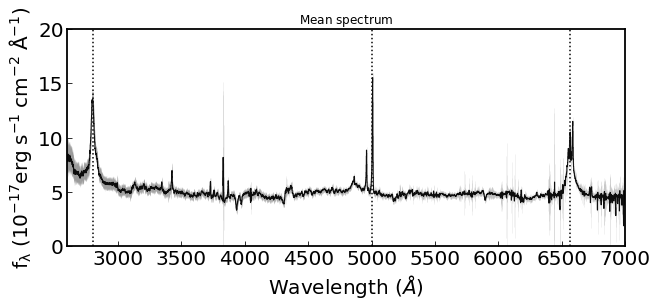

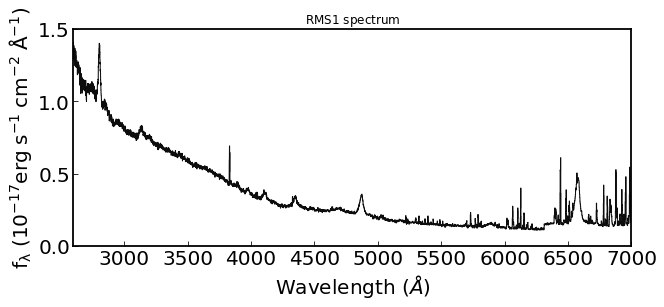

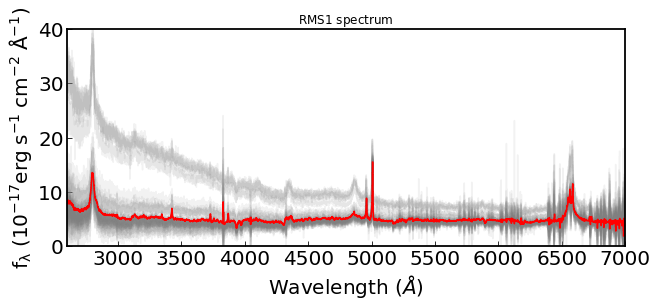

In [76]:
# Plot the mean spectrum
fig, ax = plt.subplots(1, 1, figsize=(10,4))

lam_RF = spec_mean.spectral_axis.value/(1 + z)

ax.errorbar(lam_RF, spec_mean.flux.value, yerr=spec_mean.uncertainty.array,
             color='gray', elinewidth=1, capthick=0, capsize=0, alpha=0.1)
ax.step(lam_RF, spec_mean.flux.value, 'k', lw=1)

ax.plot([5007,5007],[0,20],'k:')
ax.plot([6563,6563],[0,20],'k:')
ax.plot([2800,2800],[0,20],'k:')
ax.set_xlim(2600, 7000)
#m.Plotline(wave_samp, 0, 20)
ax.set_ylim(0, 20)
ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)', fontsize=20)
ax.set_xlabel(r'Wavelength ($\AA$)', fontsize=20)
ax.set_title(r'$\rm Mean\ spectrum$')

# Plot the rms spectrum
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.errorbar(lam_RF, spec_rms.flux.value, yerr=spec_rms.uncertainty.array,
             color='gray',elinewidth=0.,capthick=0,capsize=0,alpha=0.1)
ax.step(lam_RF, spec_rms.flux.value, 'k', lw=1)
ax.set_xlim(2600, 7000)
ax.set_ylim(0, 1.5)
plt.ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)', fontsize=20)
ax.set_xlabel(r'Wavelength ($\AA$)', fontsize=20)
ax.set_title(r'$\rm RMS1\ spectrum$')

fig, ax = plt.subplots(1, 1, figsize=(10,4))

# Read all the files
for f in spectra_file_names:
    # Read the spectrum file
    hdul = fits.open(f)
    wave = (10**hdul[1].data['loglam'])
    flux = (hdul[1].data['flux'])
    z = hdul[2].data['z'][0]
    ax.step(wave/(1 + z), flux, 'gray', alpha=0.1)

ax.step(lam_RF, spec_mean.flux.value, 'r', alpha=1)
ax.set_xlim(2600, 7000)
ax.set_ylim(0, 40)
ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)', fontsize=20)
ax.set_xlabel(r'Wavelength ($\AA$)', fontsize=20)
ax.set_title(r'$\rm RMS1\ spectrum$')

### 2. Fit the mean spectrum

In [77]:
"""
Create parameter file
lambda    complexname  minwav maxwav linename ngauss inisca minsca maxsca inisig minsig maxsig voff vindex windex findex fvalue vary
"""

newdata = np.rec.array([
(6564.61, r'H$\alpha$', 6400, 6800, 'Ha_br',   2, 0.1, 0.0, 1e10, 5e-3, 0.004,  0.05,   0.015, 0, 0, 0, 0.05 , 1),
(6564.61, r'H$\alpha$', 6400, 6800, 'Ha_na',   1, 0.1, 0.0, 1e10, 1e-3, 5e-4,   0.0017, 0.01,  1, 1, 0, 0.002, 1),
(6549.85, r'H$\alpha$', 6400, 6800, 'NII6549', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 5e-3,  1, 1, 1, 0.001, 1),
(6585.28, r'H$\alpha$', 6400, 6800, 'NII6585', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 5e-3,  1, 1, 1, 0.003, 1),
(6718.29, r'H$\alpha$', 6400, 6800, 'SII6718', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 5e-3,  1, 1, 2, 0.001, 1),
(6732.67, r'H$\alpha$', 6400, 6800, 'SII6732', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 5e-3,  1, 1, 2, 0.001, 1),

(4862.68, r'H$\beta$', 4640, 5100, 'Hb_br',     1, 0.1, 0.0, 1e10, 5e-3, 0.004,  0.05,   0.01, 0, 0, 0, 0.01 , 1),
(4862.68, r'H$\beta$', 4640, 5100, 'Hb_na',     1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 0.01, 1, 1, 0, 0.002, 1),
(4960.30, r'H$\beta$', 4640, 5100, 'OIII4959c', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 0.01, 1, 1, 0, 0.002, 1),
(5008.24, r'H$\beta$', 4640, 5100, 'OIII5007c', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 0.01, 1, 1, 0, 0.004, 1),
#(4960.30, 'Hb', 4640, 5100, 'OIII4959w',   1, 0.1, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.001, 1),
#(5008.24, 'Hb', 4640, 5100, 'OIII5007w',   1, 0.1, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.002, 1),
(4687.02, r'H$\beta$', 4640, 5100, 'HeII4687_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.004,  0.05,   0.005, 0, 0, 0, 0.001, 1),
(4687.02, r'H$\beta$', 4640, 5100, 'HeII4687_na', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 0.005, 1, 1, 0, 0.001, 1),

#(3934.78, 'CaII', 3900, 3960, 'CaII3934' , 2, 0.1, 0.0, 1e10, 1e-3, 3.333e-4, 0.0017, 0.01, 99, 0, 0, -0.001, 1),

#(3728.48, 'OII', 3650, 3800, 'OII3728', 1, 0.1, 0.0, 1e10, 1e-3, 3.333e-4, 0.0017, 0.01, 1, 1, 0, 0.001, 1),
    
#(3426.84, 'NeV', 3380, 3480, 'NeV3426',    1, 0.1, 0.0, 1e10, 1e-3, 3.333e-4, 0.0017, 0.01, 0, 0, 0, 0.001, 1),
#(3426.84, 'NeV', 3380, 3480, 'NeV3426_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.0025,   0.02,   0.01, 0, 0, 0, 0.001, 1),

(2798.75, 'MgII', 2700, 2900, 'MgII_br', 3, 0.1, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.0017, 0, 0, 0, 0.05, 1),
(2798.75, 'MgII', 2700, 2900, 'MgII_na1', 1, 0.1, 0.0, 1e10, 1e-3, 5e-4, 0.0017, 0.01, 1, 1, 0, 0.002, 1),
(2798.75, 'MgII', 2700, 2900, 'MgII_na2', 1, 0.1, 0.0, 1e10, 1e-3, 5e-4, 0.0017, 0.01, 1, 1, 0, 0.002, 1),
],

formats = 'float32,      a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32,   float32, int32',
names  =  ' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,  voff,     vindex, windex,  findex,  fvalue,  vary')

# Header
hdr = fits.Header()
hdr['lambda'] = 'Vacuum Wavelength in Ang'
hdr['minwav'] = 'Lower complex fitting wavelength range'
hdr['maxwav'] = 'Upper complex fitting wavelength range'
hdr['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr['inisca'] = 'Initial guess of line scale [in ??]'
hdr['minsca'] = 'Lower range of line scale [??]'
hdr['maxsca'] = 'Upper range of line scale [??]'

hdr['inisig'] = 'Initial guess of linesigma [in lnlambda]'
hdr['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr['vary'] = 'Whether or not to vary the line parameters (set to 0 to fix the line parameters to initial values)'

# Save line info
hdu = fits.BinTableHDU(data=newdata, header=hdr, name='data')
hdu.writeto(os.path.join(path_ex, 'qsopar.fits'), overwrite=True)

In [78]:
from astropy.table import Table
Table(newdata)

<Table length=15>
 lambda  compname  minwav  maxwav   linename  ngauss  inisca  minsca     maxsca     inisig  minsig  maxsig   voff  vindex windex findex  fvalue  vary
float32  bytes20  float32 float32   bytes20   int32  float32 float32    float32    float32 float32 float32 float32 int32  int32  int32  float32 int32
------- --------- ------- ------- ----------- ------ ------- ------- ------------- ------- ------- ------- ------- ------ ------ ------ ------- -----
6564.61 H$\alpha$  6400.0  6800.0       Ha_br      2     0.1     0.0 10000000000.0   0.005   0.004    0.05   0.015      0      0      0    0.05     1
6564.61 H$\alpha$  6400.0  6800.0       Ha_na      1     0.1     0.0 10000000000.0   0.001  0.0005  0.0017    0.01      1      1      0   0.002     1
6549.85 H$\alpha$  6400.0  6800.0     NII6549      1     0.1     0.0 10000000000.0   0.001 0.00023  0.0017   0.005      1      1      1   0.001     1
6585.28 H$\alpha$  6400.0  6800.0     NII6585      1     0.1     0.0 10000000000.0   0.001 0.00023  0.0017   0.005      1      1      1   0.003     1
6718.29 H$\alpha$  6400.0  6800.0     SII6718      1     0.1     0.0 10000000000.0   0.001 0.00023  0.0017   0.005      1      1      2   0.001     1
6732.67 H$\alpha$  6400.0  6800.0     SII6732      1     0.1     0.0 10000000000.0   0.001 0.00023  0.0017   0.005      1      1      2   0.001     1
4862.68  H$\beta$  4640.0  5100.0       Hb_br      1     0.1     0.0 10000000000.0   0.005   0.004    0.05    0.01      0      0      0    0.01     1
4862.68  H$\beta$  4640.0  5100.0       Hb_na      1     0.1     0.0 10000000000.0   0.001 0.00023  0.0017    0.01      1      1      0   0.002     1
 4960.3  H$\beta$  4640.0  5100.0   OIII4959c      1     0.1     0.0 10000000000.0   0.001 0.00023  0.0017    0.01      1      1      0   0.002     1
5008.24  H$\beta$  4640.0  5100.0   OIII5007c      1     0.1     0.0 10000000000.0   0.001 0.00023  0.0017    0.01      1      1      0   0.004     1
4687.02  H$\beta$  4640.0  5100.0 HeII4687_br      1     0.1     0.0 10000000000.0   0.005   0.004    0.05   0.005      0      0      0   0.001     1
4687.02  H$\beta$  4640.0  5100.0 HeII4687_na      1     0.1     0.0 10000000000.0   0.001 0.00023  0.0017   0.005      1      1      0   0.001     1
2798.75      MgII  2700.0  2900.0     MgII_br      3     0.1     0.0 10000000000.0   0.005   0.004    0.05  0.0017      0      0      0    0.05     1
2798.75      MgII  2700.0  2900.0    MgII_na1      1     0.1     0.0 10000000000.0   0.001  0.0005  0.0017    0.01      1      1      0   0.002     1
2798.75      MgII  2700.0  2900.0    MgII_na2      1     0.1     0.0 10000000000.0   0.001  0.0005  0.0017    0.01      1      1      0   0.002     1

### 3. Fit the mean spectrum

Reading parameter file: data/RM_017/qsopar.fits


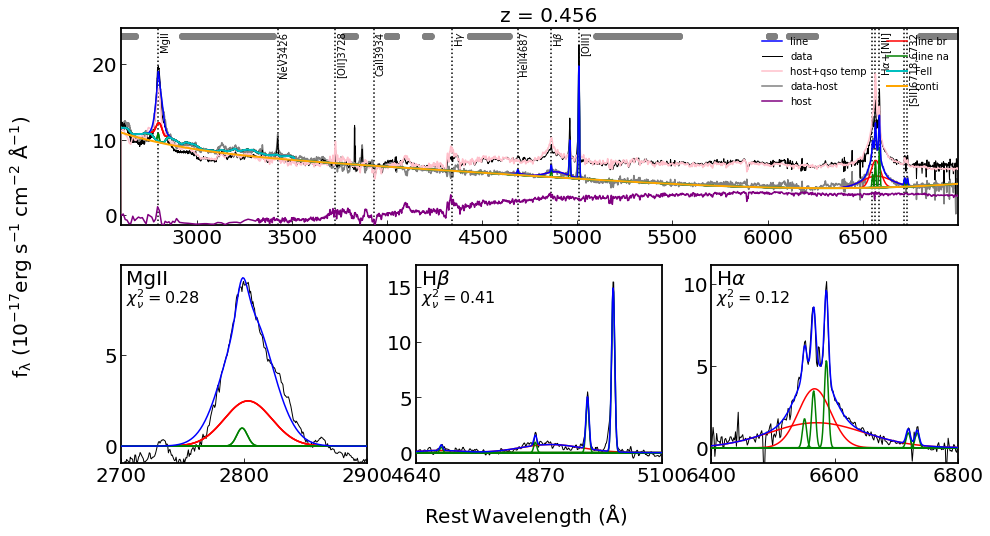

In [79]:
# Prepare the mean spectrum data
mask_finite = np.isfinite(spec_mean.flux.value)
lam = spec_mean.spectral_axis.value[mask_finite]
flux = spec_mean.flux.value[mask_finite]
err = spec_mean.uncertainty.array[mask_finite]

q0 = QSOFit(lam, flux, err, z, path=path_ex)

wave_range = np.array([2600, 7000]) # remove the edges

pp0 = np.array([0, 2000, 0, 0, 2000, 0, 1, -1.5, 0, 15000, 0.5, 0, 0, 0])

# one important note  set FWHM of Fe II to 3000 km/s in the source code to improve the fitting!
# Do the fitting
q0.Fit(param_file_name='qsopar.fits', name=None, nsmooth=1, and_or_mask=False, deredden=True, reject_badpix=False, wave_range=wave_range, 
    wave_mask=None, decomposition_host=True, BC03=True, Mi=None, host_line_mask=False, npca_gal=10, npca_qso=5,
    Fe_uv_op=True, poly=True, BC=False, rej_abs=False, MC=False, nsamp=200, initial_guess=pp0, n_pix_min_host=np.inf,
    linefit=True, save_result=True, plot_fig=True, save_fig=False, plot_line_name=True, plot_legend=True)

# Get the mean param L5100, L3000, BL_mean, host, which will be used later
Mean_L5100 = float(q0.all_result[np.argwhere(q0.all_result_name=='L5100')])
Mean_L3000 = float(q0.all_result[np.argwhere(q0.all_result_name=='L3000')])
#BL_mean = m.interp(q0.wave, q0.line_flux - q0.f_line_narrow, z=q0.z)
#host = m.interp(q0.wave*(1+z), q0.host)
BL_mean = q0.line_flux - q0.f_line_narrow_model
host = q0.host

### 4. Fit the host component with pPXF

In [80]:
def ppxf_host(rest_wv, fx, error, redshift, wv_min=4125, wv_max=5350, plot=None):
    "fit the host galaxy to get the stellar velocity dispersion. "

    ppxf_dir = path.dirname(path.realpath(lib.__file__))
    # Only use the wavelength range in common between galaxy and stellar library.
    #
    mask = np.where( (rest_wv > wv_min) & (rest_wv < wv_max) & (error <100.), True, False)

    flux = fx[mask]
    galaxy = flux/np.median(flux)   # Normalize spectrum to avoid numerical issues
    wave = rest_wv[mask]
    err = error[mask]
    z=0 # already rest frame so z =0


    # The SDSS wavelengths are in vacuum, while the MILES ones are in air.
    # For a rigorous treatment, the SDSS vacuum wavelengths should be
    # converted into air wavelengths and the spectra should be resampled.
    # To avoid resampling, given that the wavelength dependence of the
    # correction is very weak, I approximate it with a constant factor.
    #
    wave *= np.median(util.vac_to_air(wave)/wave)


    # The noise level is chosen to give Chi^2/DOF=1 without regularization (REGUL=0).
    # A constant noise is not a bad approximation in the fitted wavelength
    # range and reduces the noise in the fit.
    #
    noise = np.full_like(galaxy, err.mean())  # Assume constant noise per pixel here

    # The velocity step was already chosen by the SDSS pipeline
    # and we convert it below to km/s
    #
    c = 299792.458  # speed of light in km/s
    velscale = c*np.log(wave[1]/wave[0])  # eq.(8) of Cappellari (2017)
    FWHM_gal = 2.76  # SDSS has an approximate instrumental resolution FWHM of 2.76A.

    #------------------- Setup templates -----------------------

    #pathname = ppxf_dir + '/miles_models/Mun1.30*.fits' 
    pathname = ppxf_dir + '/miles_models/Eun1.30*.fits' 
    miles = lib.miles(pathname, velscale, FWHM_gal)


    # The stellar templates are reshaped below into a 2-dim array with each
    # spectrum as a column, however we save the original array dimensions,
    # which are needed to specify the regularization dimensions
    #
    reg_dim = miles.templates.shape[1:]
    stars_templates = miles.templates.reshape(miles.templates.shape[0], -1)

    # See the pPXF documentation for the keyword REGUL,
    regul_err = 0.013  # Desired regularization error

    # Construct a set of Gaussian emission line templates.
    # Estimate the wavelength fitted range in the rest frame.
    #
    lam_range_gal = np.array([np.min(wave), np.max(wave)])/(1. + z)
    gas_templates, gas_names, line_wave = util.emission_lines(
        miles.ln_lam_temp, lam_range_gal, FWHM_gal,
        tie_balmer=False, limit_doublets=False)

    # Combines the stellar and gaseous templates into a single array.
    # During the PPXF fit they will be assigned a different kinematic
    # COMPONENT value
    #

    templates = np.column_stack([stars_templates, gas_templates])

    #-----------------------------------------------------------

    # The galaxy and the template spectra do not have the same starting wavelength.
    # For this reason an extra velocity shift DV has to be applied to the template
    # to fit the galaxy spectrum. We remove this artificial shift by using the
    # keyword VSYST in the call to PPXF below, so that all velocities are
    # measured with respect to DV. This assume the redshift is negligible.
    # In the case of a high-redshift galaxy one should de-redshift its
    # wavelength to the rest frame before using the line below as described
    # in PPXF_EXAMPLE_KINEMATICS_SAURON and Sec.2.4 of Cappellari (2017)
    #
    c = const.c.to(u.km/u.s).value
    dv = c*(miles.ln_lam_temp[0] - np.log(wave[0]))  # eq.(8) of Cappellari (2017)
    vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
    start = [vel, 180]  # (km/s), starting guess for [V, sigma]

    n_temps = stars_templates.shape[1]
    n_forbidden = np.sum(["[" in a for a in gas_names])  # forbidden lines contain "[*]"
    n_balmer = len(gas_names) - n_forbidden

    # Assign component=0 to the stellar templates, component=1 to the Balmer
    # gas emission lines templates and component=2 to the forbidden lines.
    component = [0]*n_temps + [1]*n_balmer + [2]*n_forbidden
    gas_component = np.array(component) > 0  # gas_component=True for gas templates

    # Fit (V, sig, h3, h4) moments=4 for the stars
    # and (V, sig) moments=2 for the two gas kinematic components
    moments = [4, 4, 4]

    # Adopt the same starting value for the stars and the two gas components
    start = [start, start, start]

    # If the Balmer lines are tied one should allow for gas reddeining.
    # The gas_reddening can be different from the stellar one, if both are fitted.
    #gas_reddening = 0 if tie_balmer else None

    # Use qso line widths
    width_qso = [800,800,2000,2000,3000,800,800,800,800,800,3000,800,800]
    goodpixels = util.determine_goodpixels(np.log(wave), lam_range_gal, z, width=width_qso)
    # Here the actual fit starts.
    #
    # IMPORTANT: Ideally one would like not to use any polynomial in the fit
    # as the continuum shape contains important information on the population.
    # Unfortunately this is often not feasible, due to small calibration
    # uncertainties in the spectral shape. To avoid affecting the line strength of
    # the spectral features, we exclude additive polynomials (DEGREE=-1) and only use
    # multiplicative ones (MDEGREE=10). This is only recommended for population, not
    # for kinematic extraction, where additive polynomials are always recommended.
    #

    pp = ppxf(templates, galaxy, noise, velscale, start,
              plot=False, moments=moments, degree=-1, mdegree=10, vsyst=dv,
              lam=wave, clean=False, regul=1/regul_err, reg_dim=reg_dim,
              component=component, gas_component=gas_component,
              gas_names=gas_names, goodpixels=goodpixels)


    weights = pp.weights[~gas_component]  # Exclude weights of the gas templates
    weights = weights.reshape(reg_dim)/weights.sum()  # Normalized



    # calculate the band luminosity e.g., Lr
    sdss_filter = np.array([3543, 4770, 6231, 7625])
    band=np.array(['u','g', 'r', 'i'])
    filter_cen = sdss_filter[(np.abs(sdss_filter - (wave*(1+redshift)).mean() )).argmin()]
    bandn = band[(np.abs(sdss_filter - (wave*(1+redshift)).mean() )).argmin()] 
    #assume the filter width ~ 1000A
    ind=np.where( (wave*(1+redshift) > filter_cen-500) & (wave*(1+redshift) < filter_cen+500) ,True,False)
    flux_band_mean= flux[ind][np.isfinite(flux[ind])].mean()
    flux_band_mean_up = (flux[ind]+err[ind])[np.isfinite(flux[ind])].mean()
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)    
    DL = cosmo.luminosity_distance(redshift).to(u.cm).value # unit cm
    Lband = np.log10(4*np.pi*DL**2*flux_band_mean*1e-17*1000)  # assume the band widths for sdss are ~ 1000A
    Lband_up = np.log10(4*np.pi*DL**2*flux_band_mean_up*1e-17*1000)

    # calculate the SFH and error
    mass_frac_tmp = np.asarray([np.sum(weights[0:3,:])]) #mass fraction below 10^8 yr
    mass_frac_tmp_delta =np.asarray([np.sum(weights[0:4,:])-np.sum(weights[0:3,:] )]) 
    ml_tmp = np.asarray([miles.mass_to_light(weights, band=bandn)]) 

    sigma = np.round(pp.sol[0][1],1)
    sigmaerr = np.round(pp.error[0][1]*np.sqrt(pp.chi2), 1)
    stellar_mass = np.round(10**Lband/(3.8*1e33)/ml_tmp, 2) # M_sun
    stellar_mass_err = np.round(10**Lband_up/(3.8*1e33)/ml_tmp-stellar_mass, 2)
    SFR = np.round(stellar_mass*mass_frac_tmp/1e8, 2) #M_sun/yr
    SFR_err = np.round(stellar_mass*mass_frac_tmp_delta/1e8, 2) # M_sun/yr

    # Plot
    if plot == True:
        fig = plt.figure(figsize=(15,10))
        ax = plt.subplot(211)
        pp.plot()
        plt.text(0.02, 0.85,r'$\sigma$='+str(sigma)+'$\pm$'+str(sigmaerr)+r'$\rm \ km\ s^{-1}$', 
                 transform=ax.transAxes,fontsize=20)
        plt.subplot(212)
        miles.plot(weights)
        plt.tight_layout()

    data_host = np.array([sigma,sigmaerr,stellar_mass,stellar_mass,stellar_mass_err,SFR,SFR_err])
    data_host_name = np.array(['sigma','sigmaerr','stellar_mass','stellar_mass_err','SFR','SFR_err'])

    return data_host_name, data_host

Emission lines included in gas templates:
['Hgamma' 'Hbeta' '[OIII]5007_d']
[ True  True  True]
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:        78       169     0.033    -0.300
 comp.  1:         0       180    -0.005    -0.005
 comp.  2:     -2000      1000    -0.005    -0.005
chi2/DOF: 0.03571; DOF: 901; degree = -1; mdegree = 10
method = capfit; Jac calls: 6; Func calls: 142; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 43/153
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                Hgamma        nan       nan       0   180
Comp:  1                 Hbeta        nan       nan       0   180
Comp:  2          [OIII]5007_d        nan       nan   -2000  1000
-----------------------------------------------------------------
(M*/L)_r: 3.974


(array(['sigma', 'sigmaerr', 'stellar_mass', 'stellar_mass_err', 'SFR',
        'SFR_err'], dtype='<U16'),
 array([168.7, 9.4, array([5.59981856e+08]), array([5.59981856e+08]),
        array([2.36299801e+08]), array([0.]), array([0.])], dtype=object))

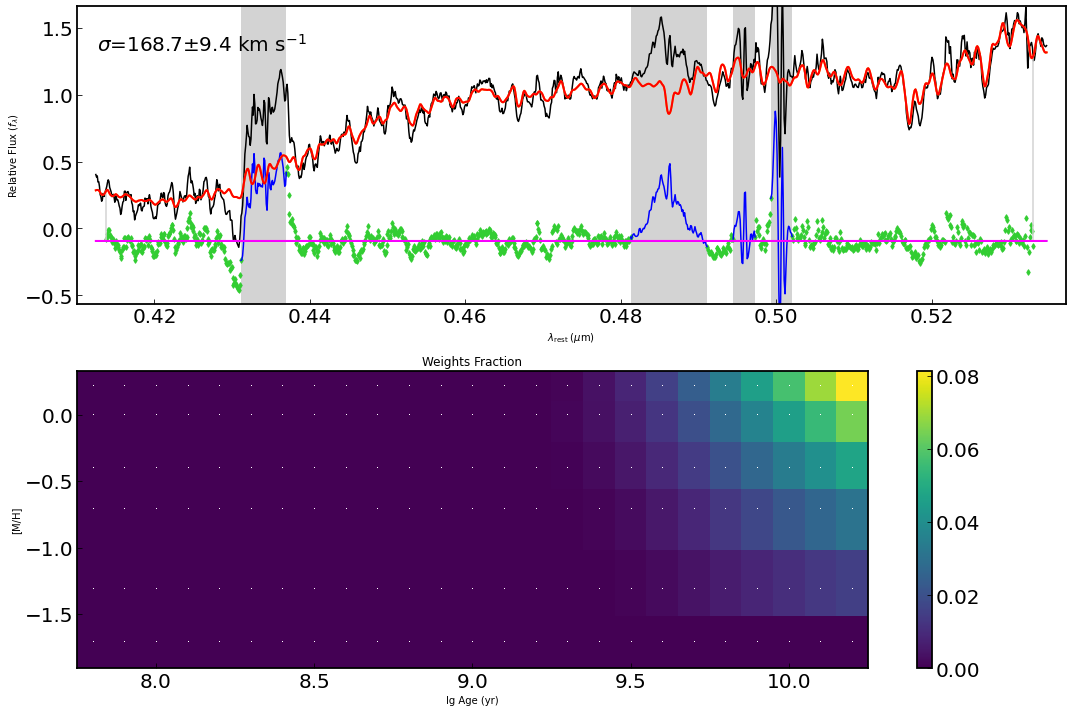

In [81]:
f = interpolate.interp1d(q0.wave_prereduced, q0.flux_prereduced, bounds_error=False, fill_value=0)
flux_total = f(q0.wave)

host = flux_total - q0.f_conti_model - q0.f_line_model # better
#host = q0.host

ppxf_host(q0.wave, host, q0.err, redshift=q0.z, wv_min=4125, wv_max=5350, plot=True)

### 5. Fix the narrow emission lines and fit the nightly spectra

In [82]:
# Read the original parameter file
hdul = fits.open(os.path.join(path_ex, 'qsopar.fits'))
data = hdul[1].data

line_names_short = np.array(['_'.join(n.split('_')[:-2]) for n in q0.gauss_result_name])
line_names_types = np.array([n.split('_')[-1] for n in q0.gauss_result_name])

for i, row in enumerate(data):
    # If narrow line
    if (row['maxsig'] < 0.0018):
        # Fix the narrow line parameters
        line_name_mask = line_names_short==row['linename']
        
        sigma_mask = line_names_types == 'sigma'
        centerwave_mask = line_names_types == 'centerwave'
        scale_mask = line_names_types == 'scale'
        
        # Set the initial value to the previous result
        data['inisig'][i] = q0.gauss_result[line_name_mask & sigma_mask][0]
        data['lambda'][i] = np.exp(q0.gauss_result[line_name_mask & centerwave_mask][0])
        data['inisca'][i] = q0.gauss_result[line_name_mask & scale_mask][0]
        
        data['vary'][i] = 0 # Fixed parameter
        
# Save line info
hdu = fits.BinTableHDU(data=data, header=hdr, name='data')
hdu.writeto(os.path.join(path_ex, 'qsopar2.fits'), overwrite=True)

In [83]:
from astropy.table import Table
Table(data)

<Table length=15>
  lambda   compname  minwav  maxwav   linename  ngauss   inisca    minsca     maxsca        inisig     minsig  maxsig   voff  vindex windex findex  fvalue  vary
 float32    str20   float32 float32    str20    int32   float32   float32    float32       float32    float32 float32 float32 int32  int32  int32  float32 int32
--------- --------- ------- ------- ----------- ------ ---------- ------- ------------- ------------- ------- ------- ------- ------ ------ ------ ------- -----
  6564.61 H$\alpha$  6400.0  6800.0       Ha_br      2        0.1     0.0 10000000000.0         0.005   0.004    0.05   0.015      0      0      0    0.05     1
6566.0957 H$\alpha$  6400.0  6800.0       Ha_na      1  3.4662938     0.0 10000000000.0  0.0005000233  0.0005  0.0017    0.01      1      1      0   0.002     0
6551.3276 H$\alpha$  6400.0  6800.0     NII6549      1  1.7775786     0.0 10000000000.0  0.0005000233 0.00023  0.0017   0.005      1      1      1   0.001     0
6586.7676 H$\alpha$  6400.0  6800.0     NII6585      1   5.332736     0.0 10000000000.0  0.0005000233 0.00023  0.0017   0.005      1      1      1   0.003     0
 6719.806 H$\alpha$  6400.0  6800.0     SII6718      1  0.9095974     0.0 10000000000.0  0.0005000233 0.00023  0.0017   0.005      1      1      2   0.001     0
6734.1895 H$\alpha$  6400.0  6800.0     SII6732      1  0.9095974     0.0 10000000000.0  0.0005000233 0.00023  0.0017   0.005      1      1      2   0.001     0
  4862.68  H$\beta$  4640.0  5100.0       Hb_br      1        0.1     0.0 10000000000.0         0.005   0.004    0.05    0.01      0      0      0    0.01     1
4862.7905  H$\beta$  4640.0  5100.0       Hb_na      1 0.94405264     0.0 10000000000.0 0.00058956444 0.00023  0.0017    0.01      1      1      0   0.002     0
 4960.408  H$\beta$  4640.0  5100.0   OIII4959c      1  4.7278666     0.0 10000000000.0 0.00058956444 0.00023  0.0017    0.01      1      1      0   0.002     0
 5008.351  H$\beta$  4640.0  5100.0   OIII5007c      1 14.9119625     0.0 10000000000.0 0.00058956444 0.00023  0.0017    0.01      1      1      0   0.004     0
  4687.02  H$\beta$  4640.0  5100.0 HeII4687_br      1        0.1     0.0 10000000000.0         0.005   0.004    0.05   0.005      0      0      0   0.001     1
 4687.122  H$\beta$  4640.0  5100.0 HeII4687_na      1 0.51103234     0.0 10000000000.0 0.00058956444 0.00023  0.0017   0.005      1      1      0   0.001     0
  2798.75      MgII  2700.0  2900.0     MgII_br      3        0.1     0.0 10000000000.0         0.005   0.004    0.05  0.0017      0      0      0    0.05     1
2798.7227      MgII  2700.0  2900.0    MgII_na1      1  0.9919443     0.0 10000000000.0  0.0015402914  0.0005  0.0017    0.01      1      1      0   0.002     0
2798.7227      MgII  2700.0  2900.0    MgII_na2      1  0.9921941     0.0 10000000000.0  0.0015402914  0.0005  0.0017    0.01      1      1      0   0.002     0

Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter file: data/RM_017/qsopar2.fits
Reading parameter fi

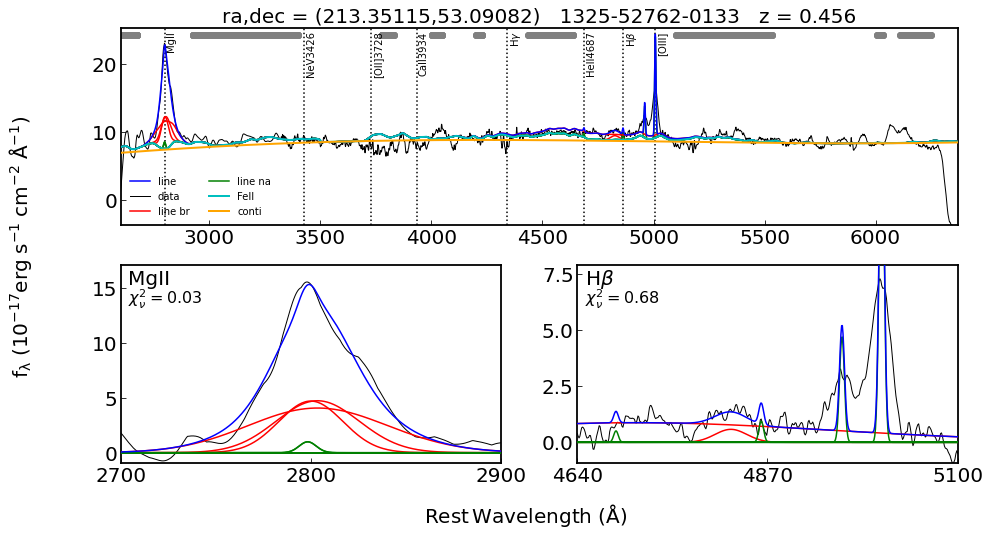

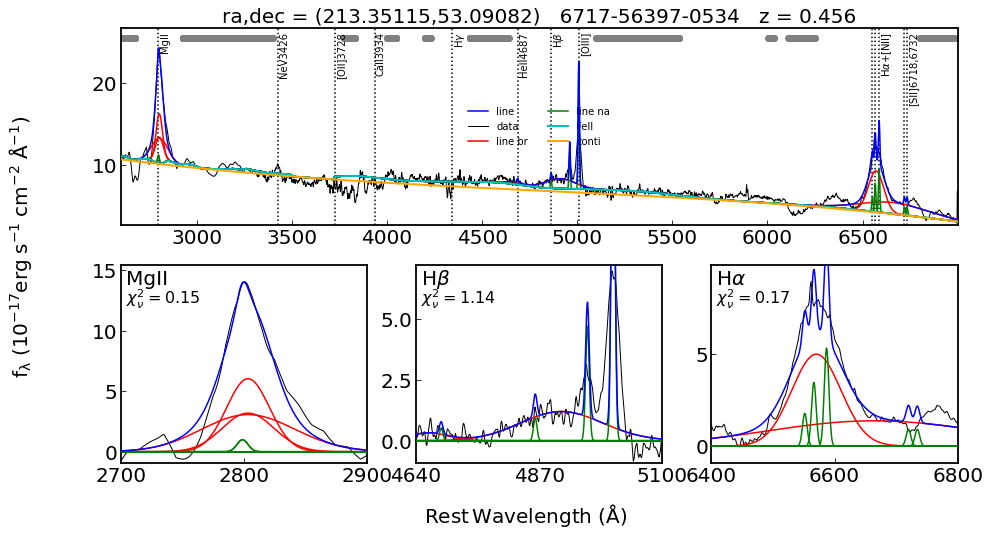

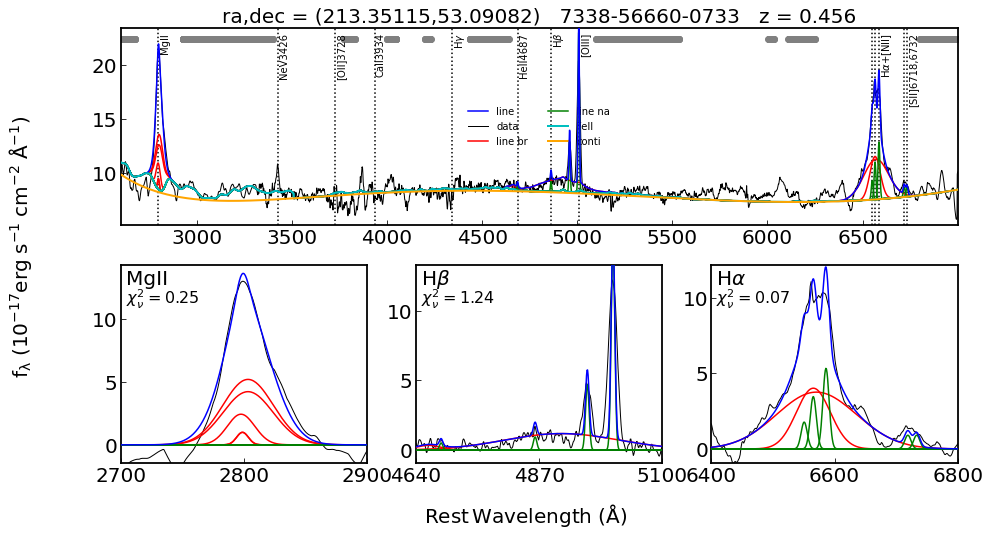

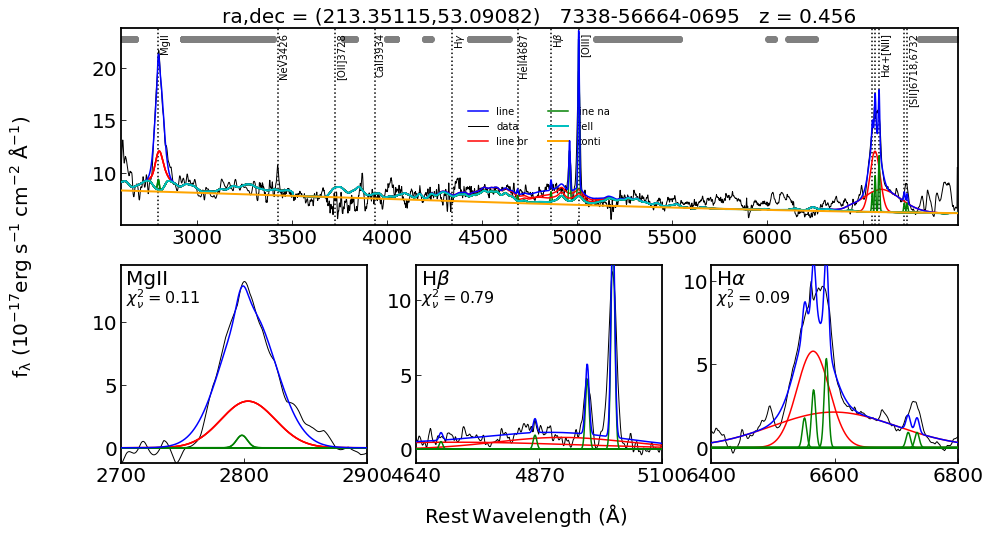

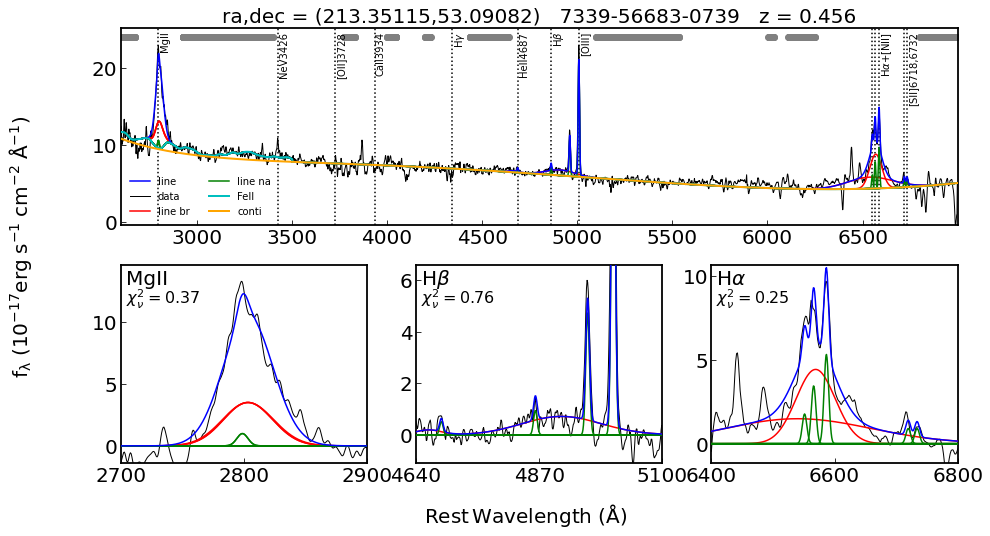

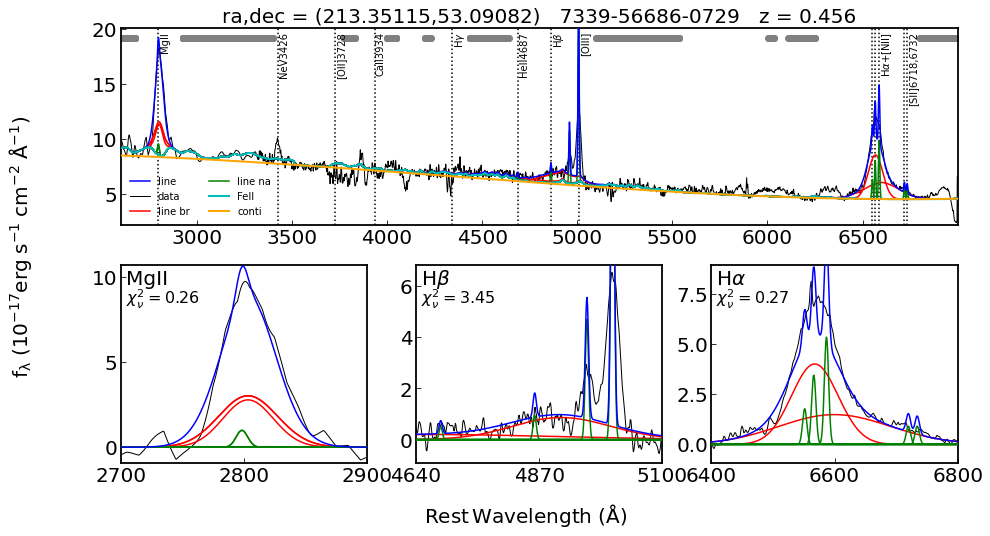

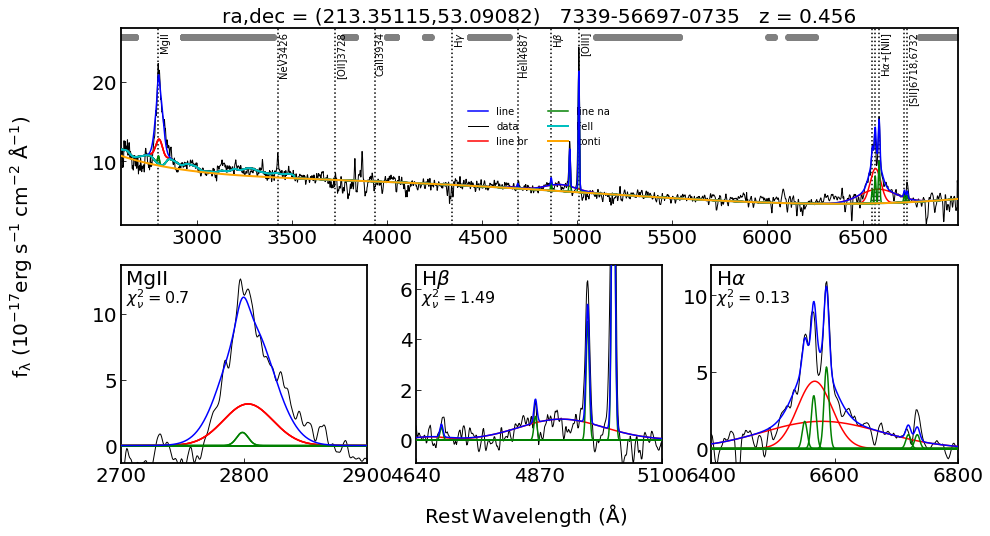

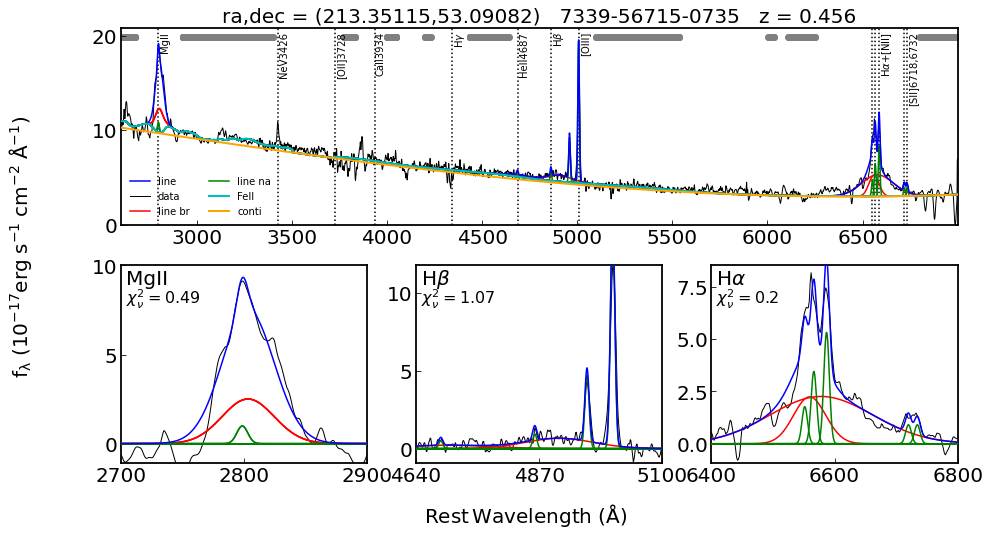

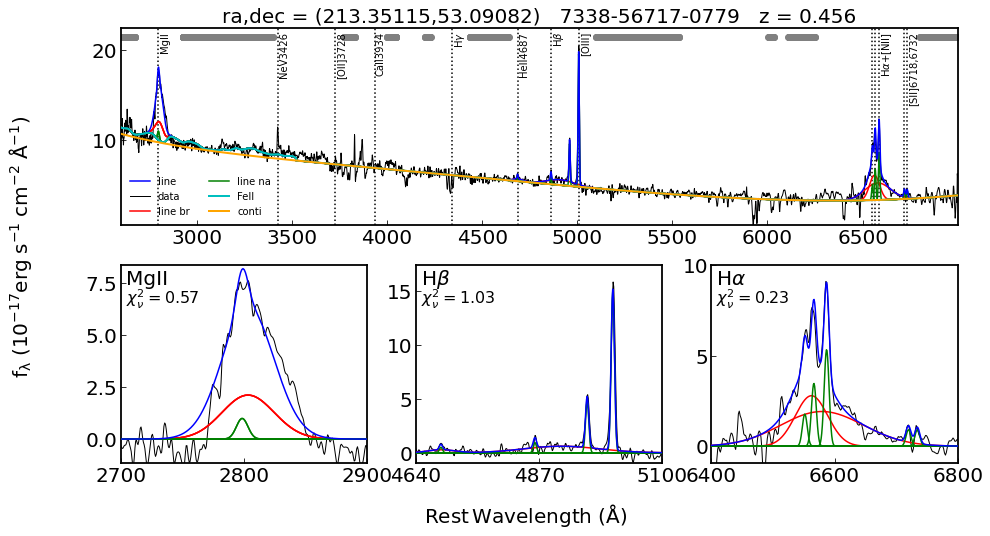

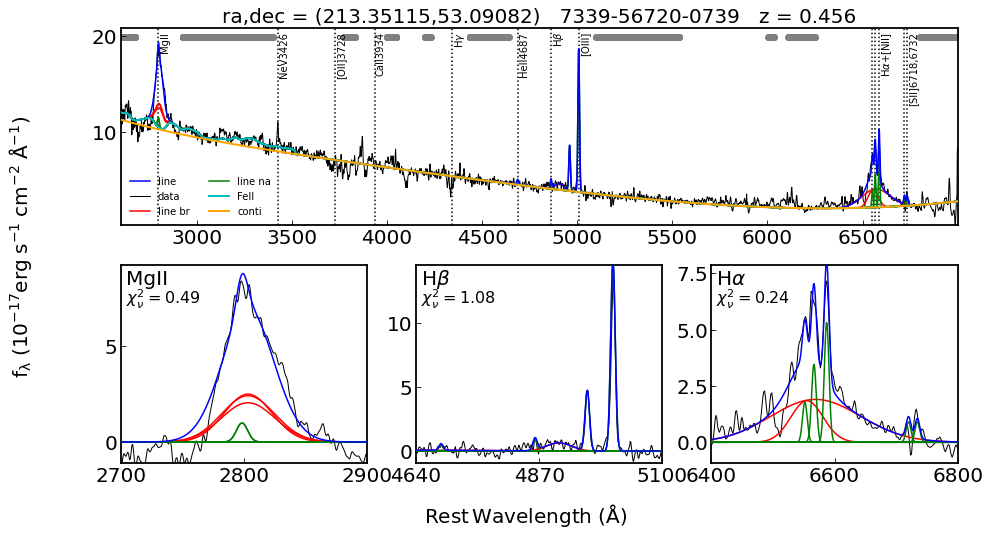

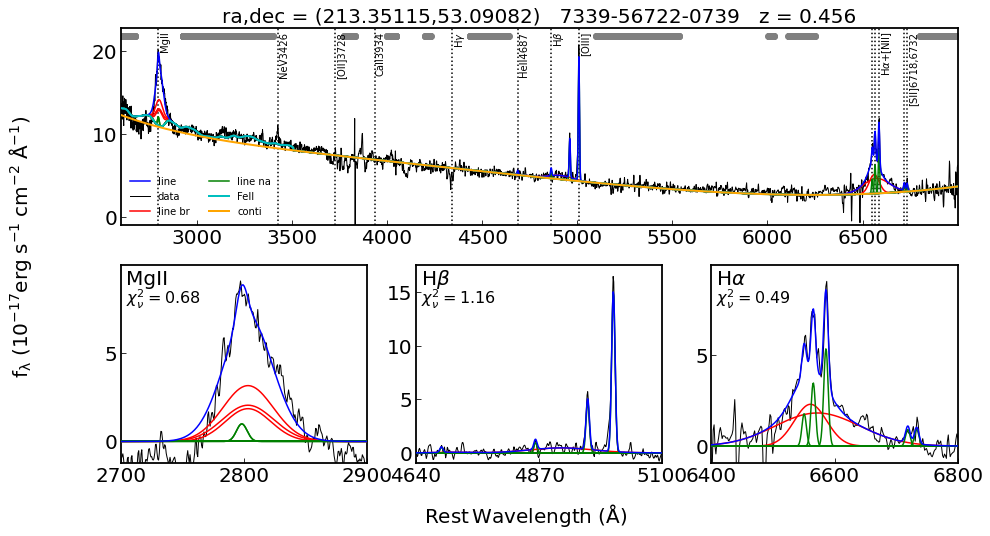

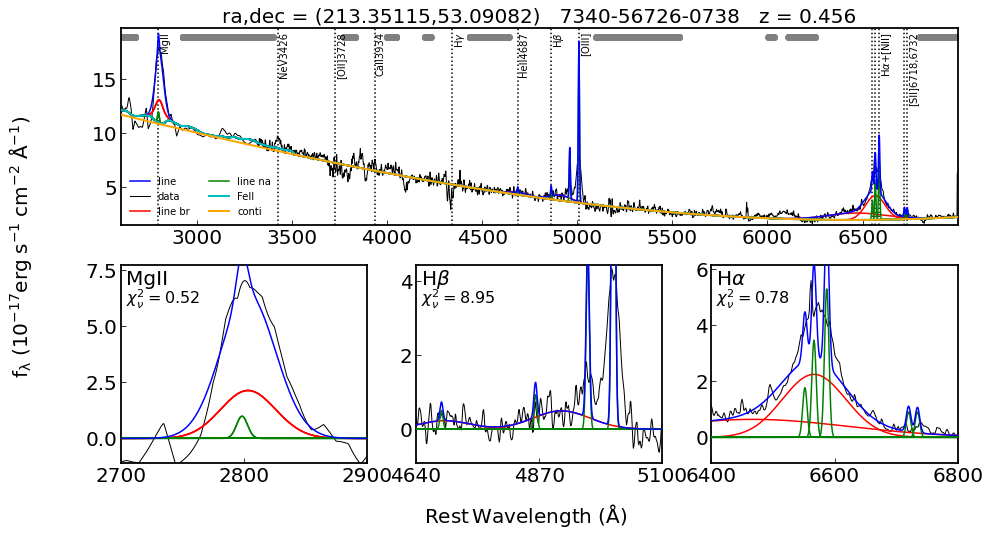

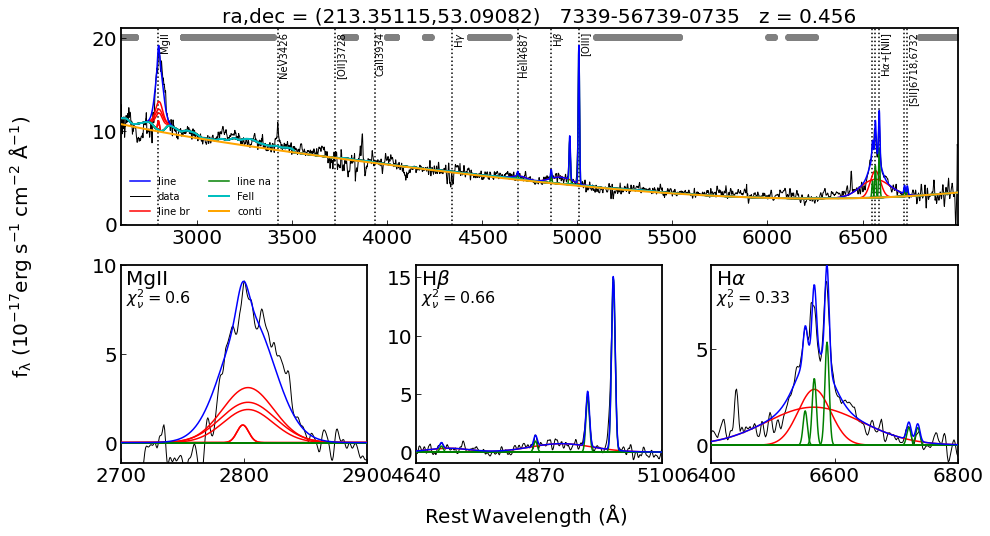

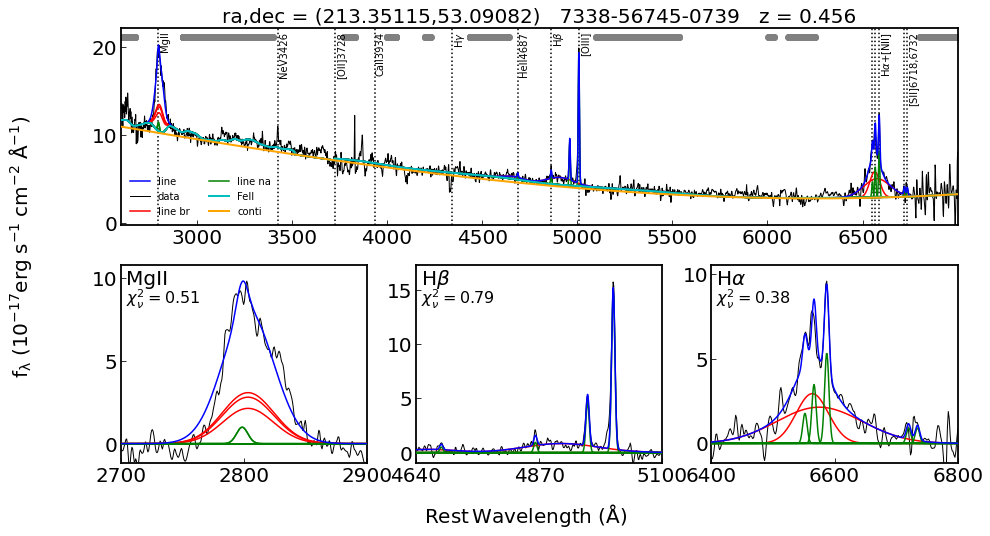

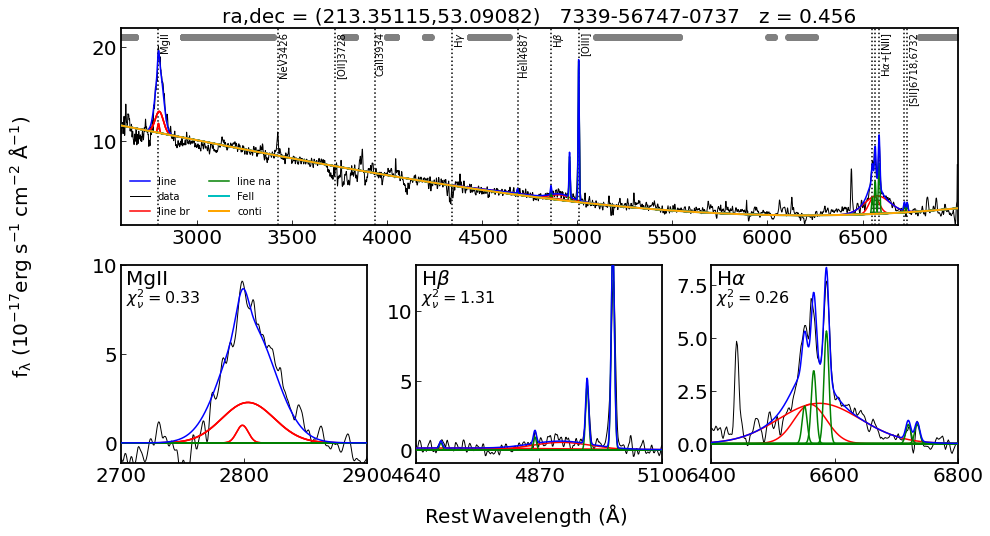

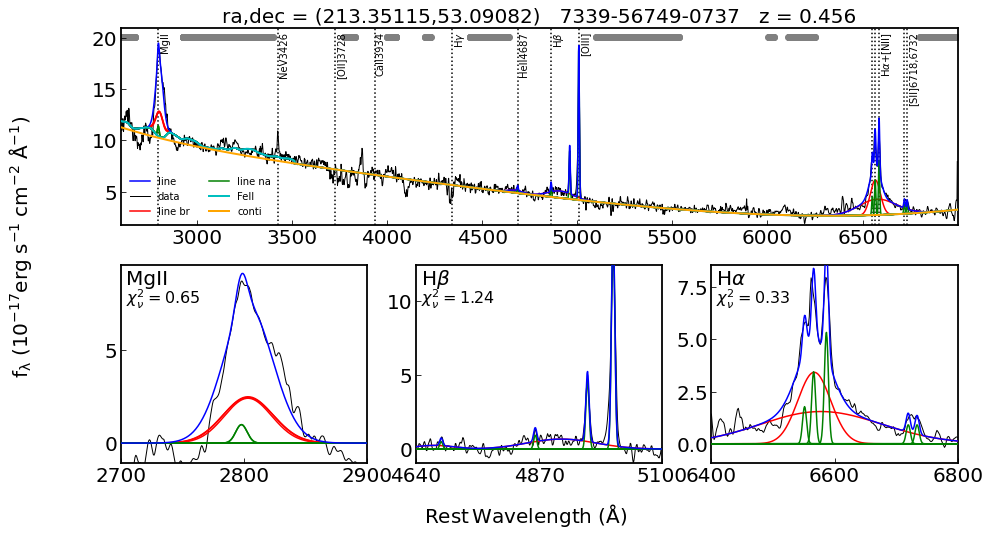

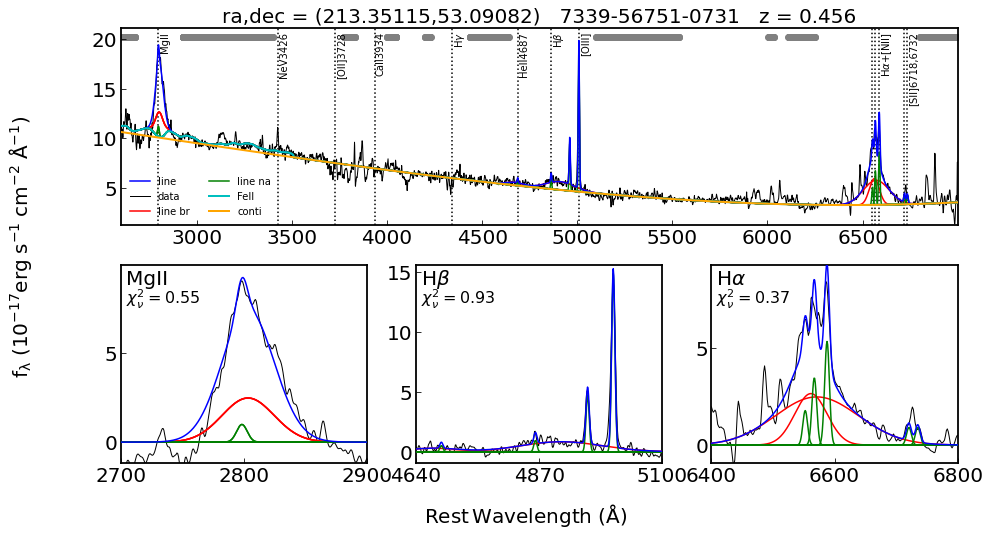

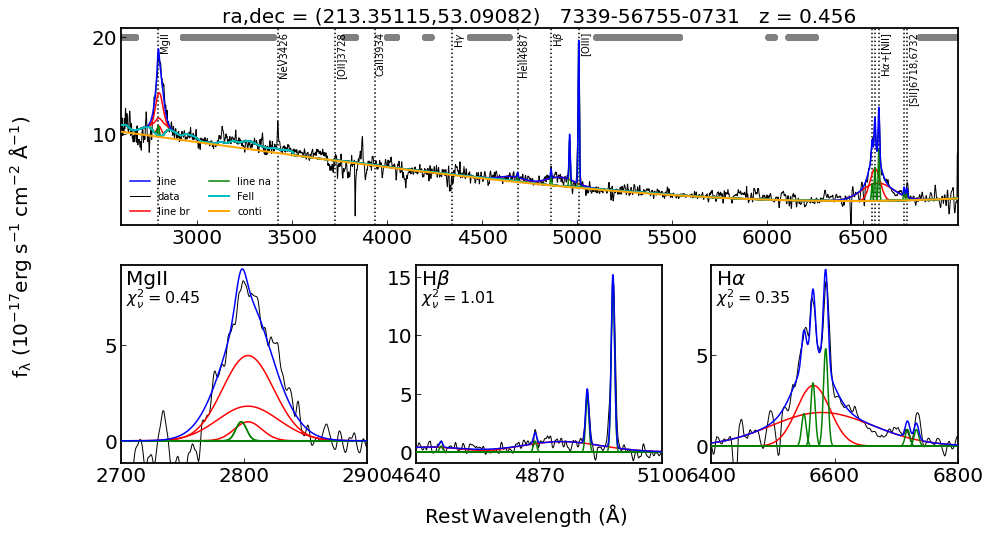

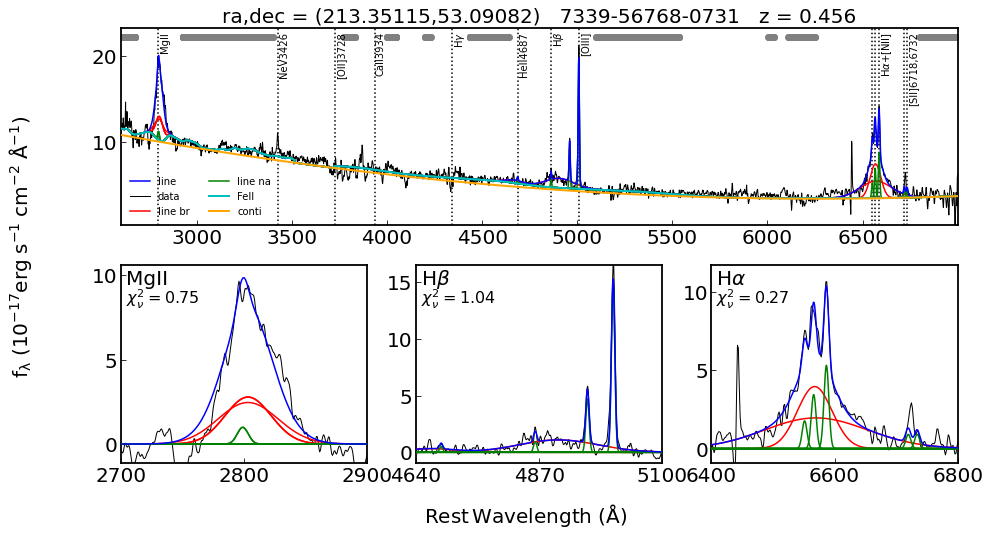

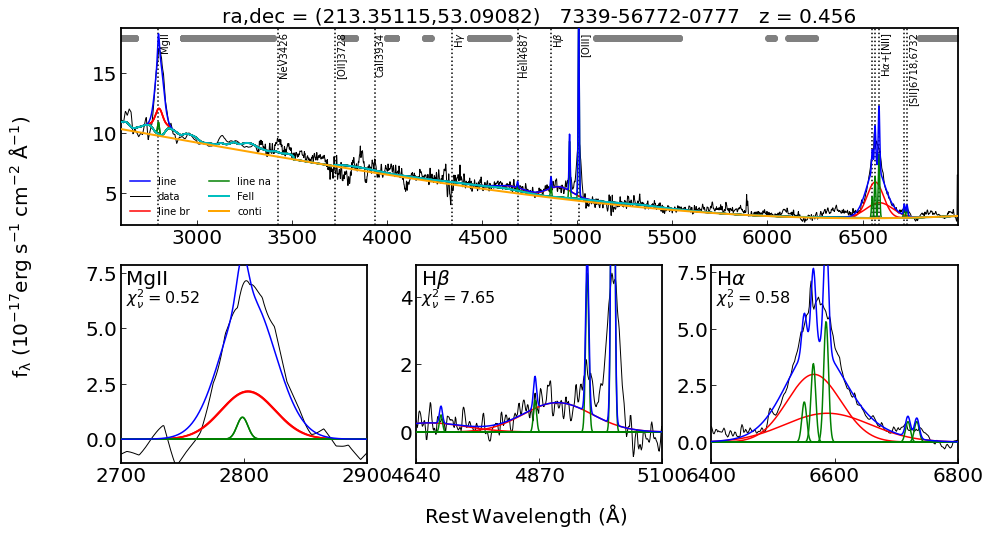

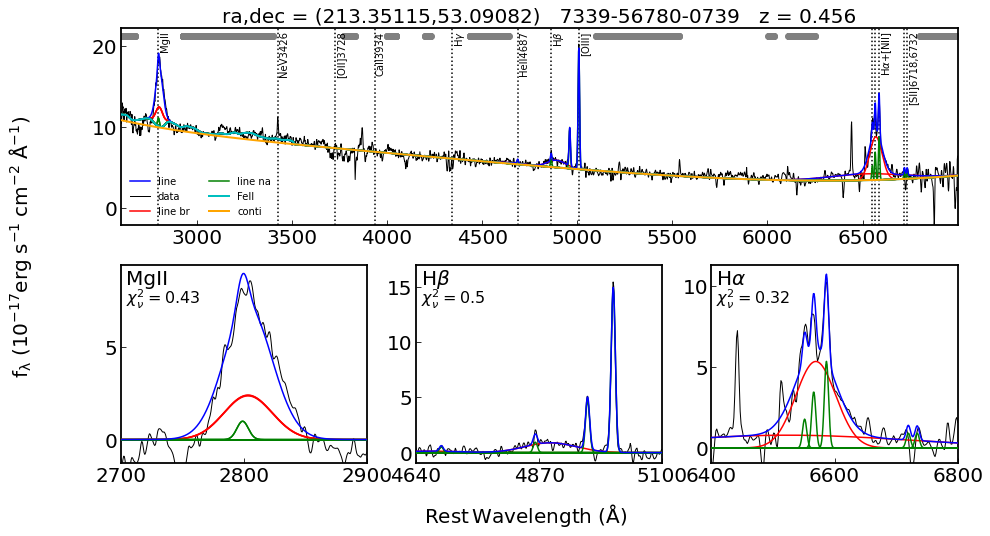

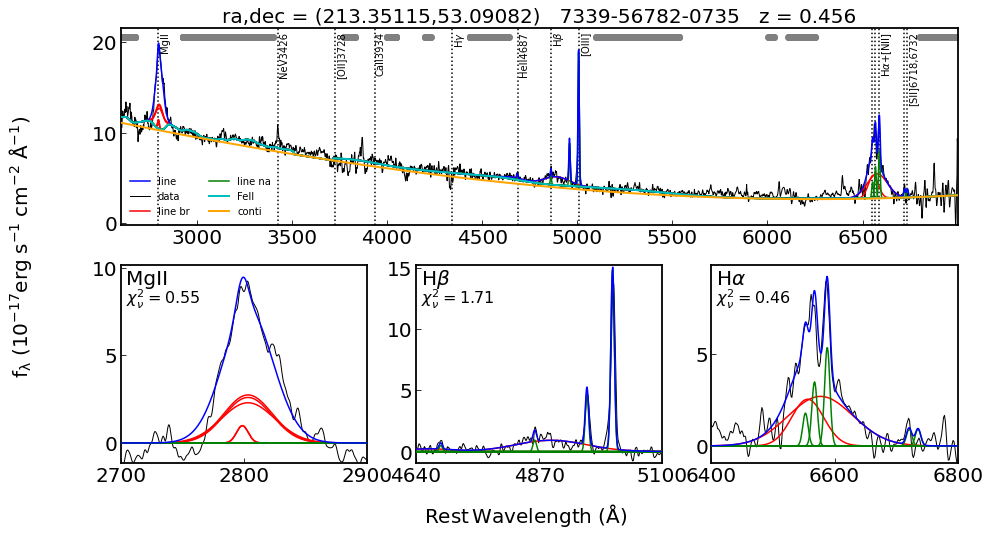

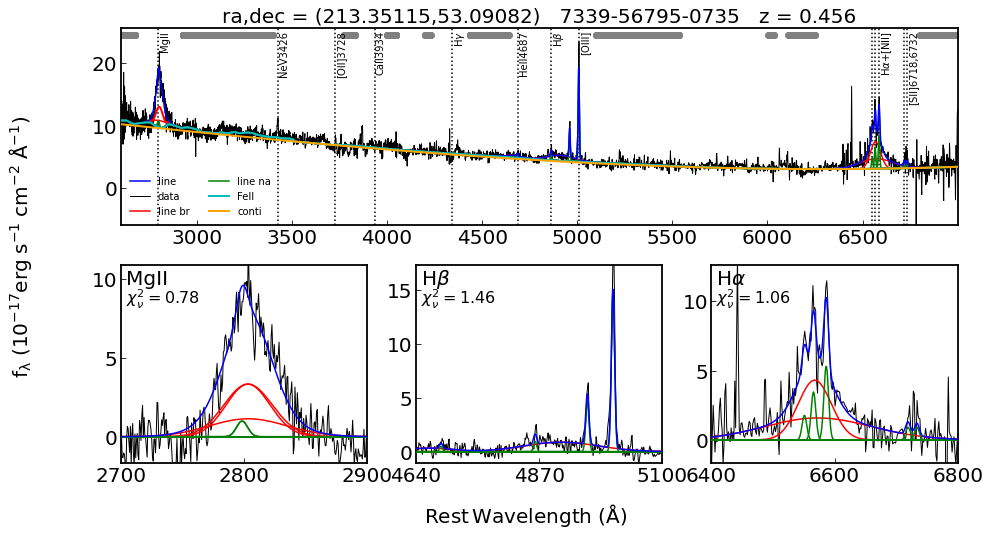

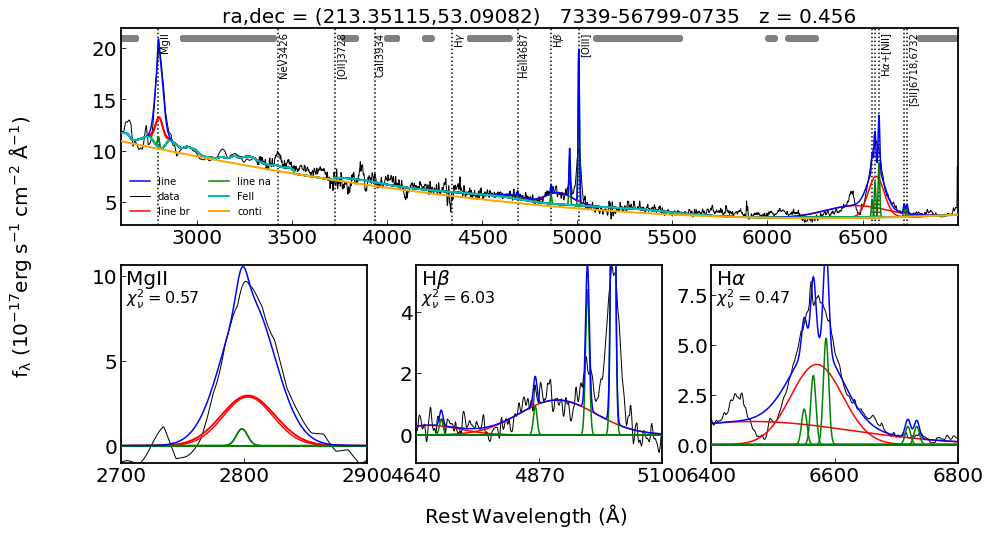

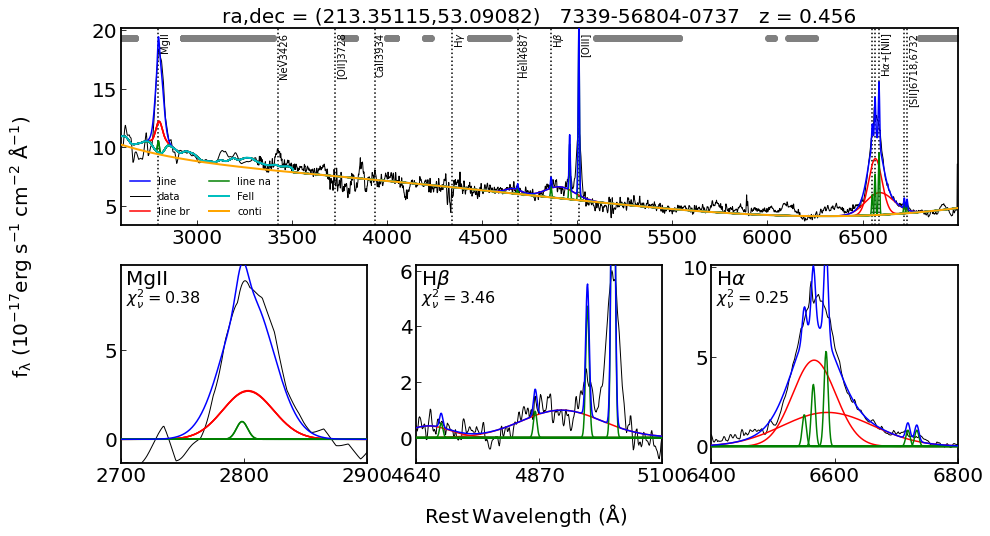

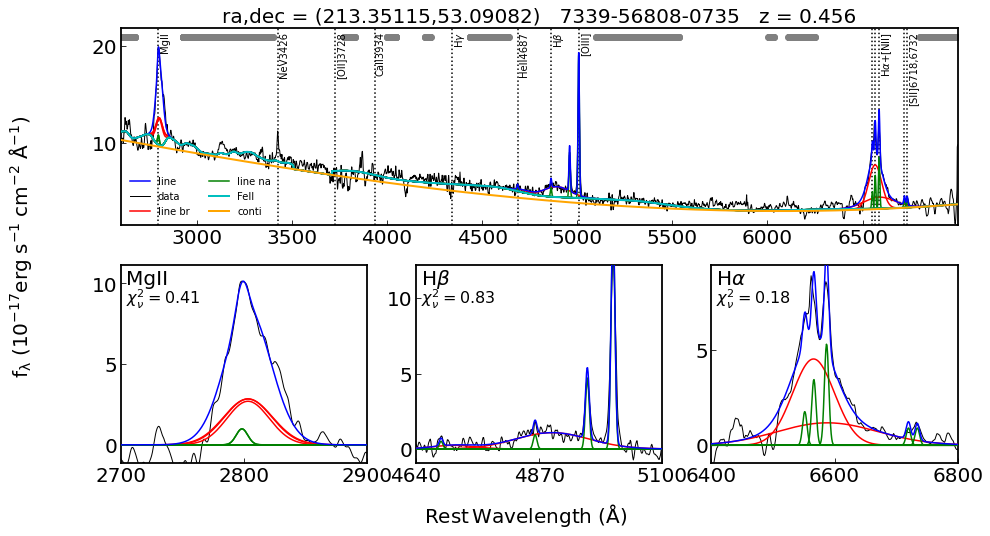

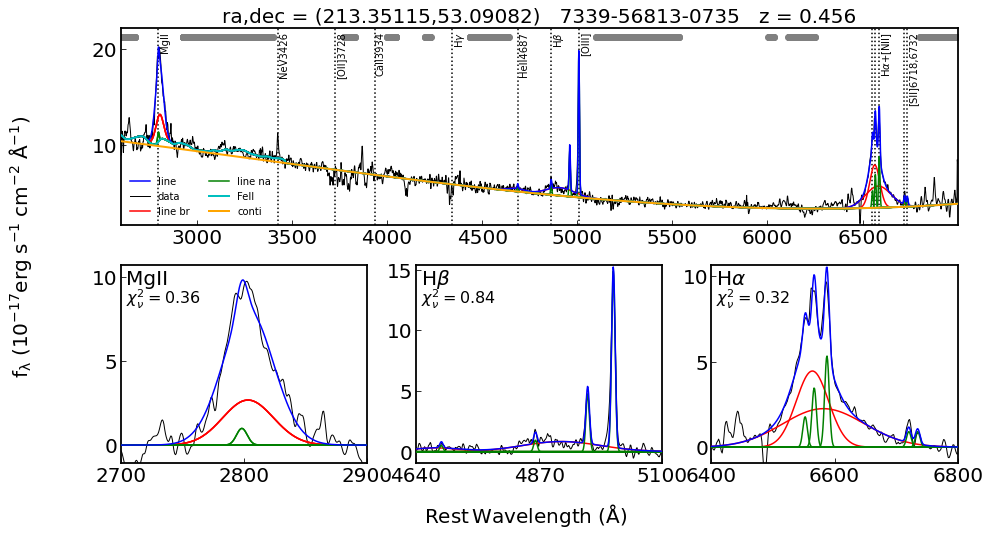

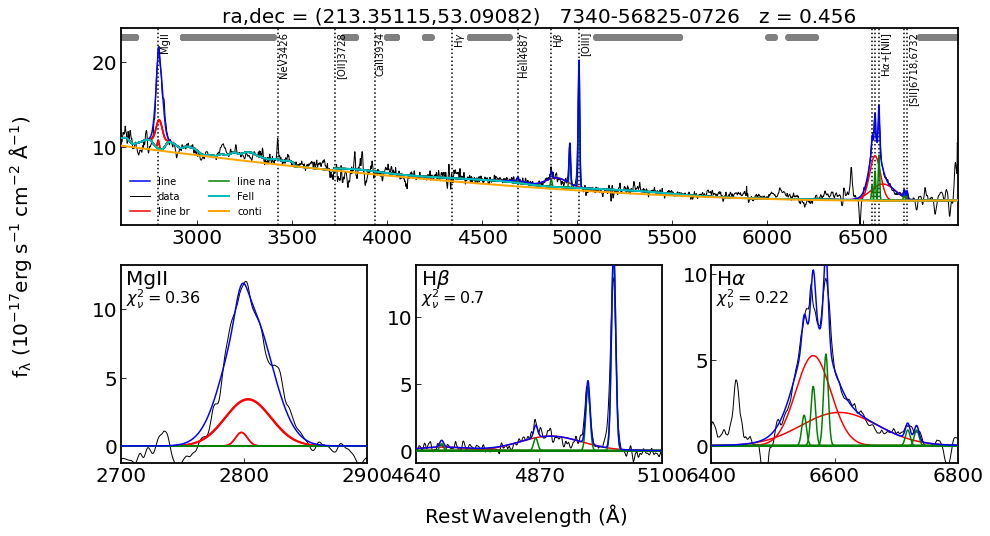

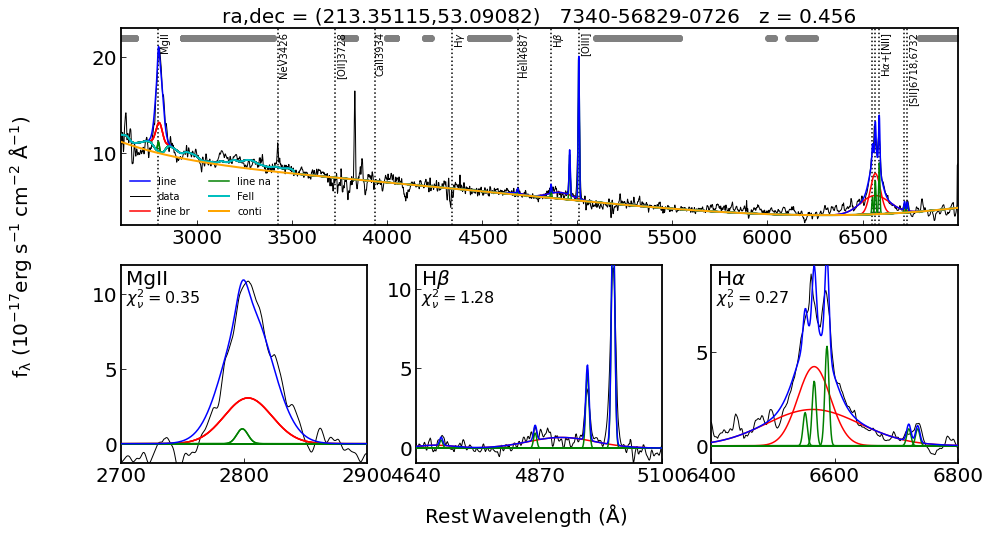

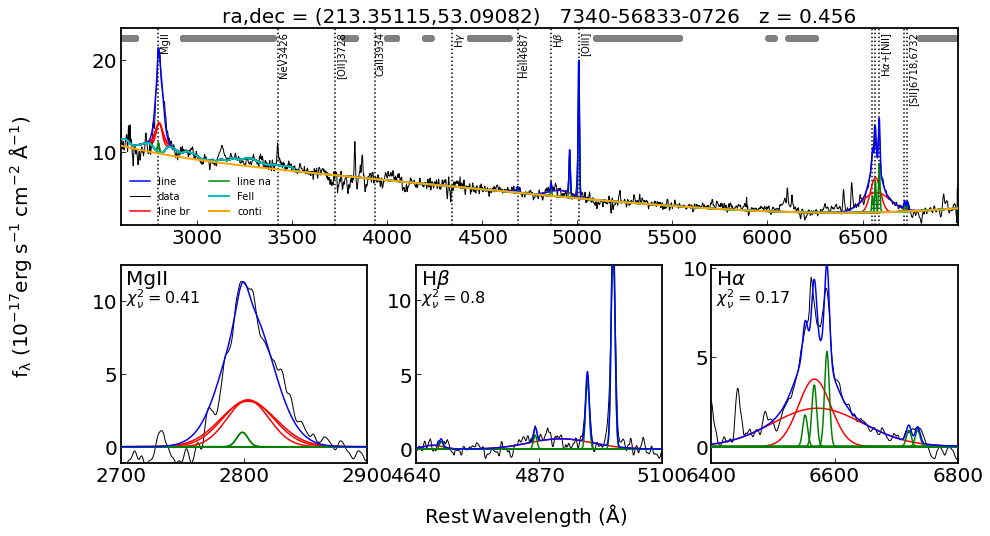

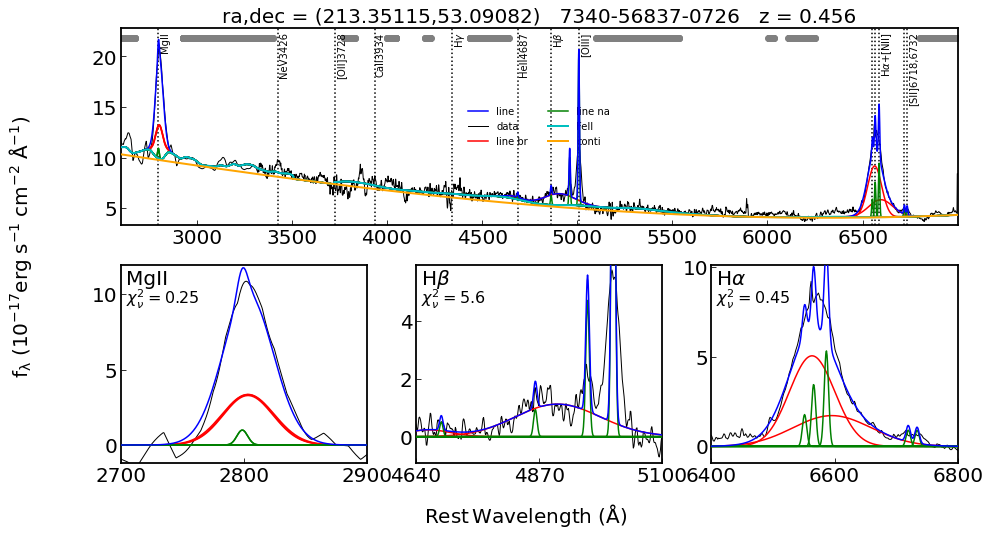

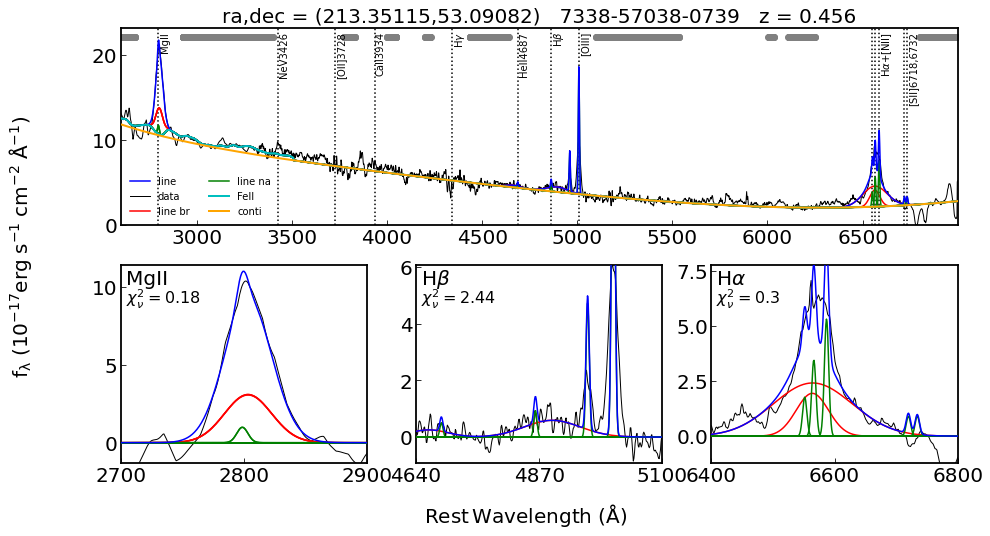

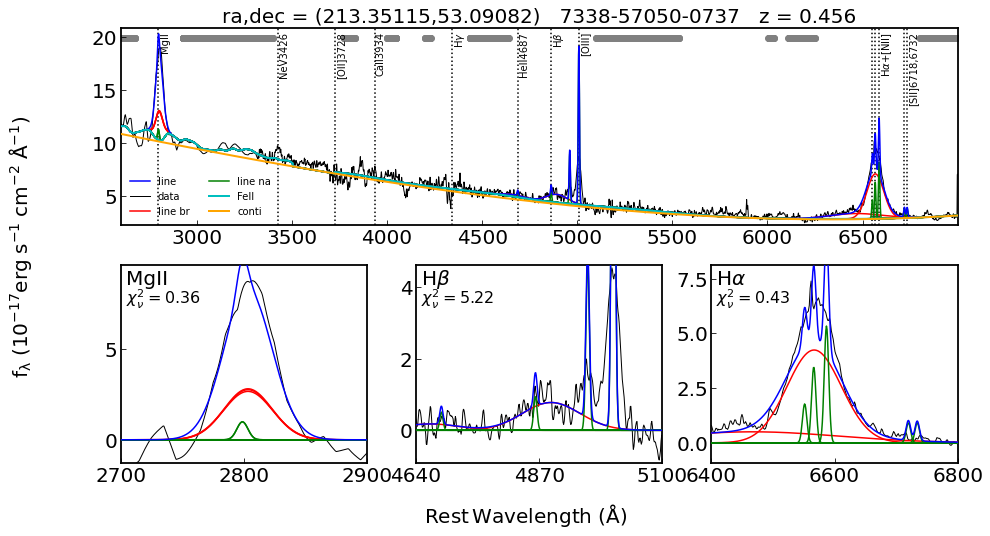

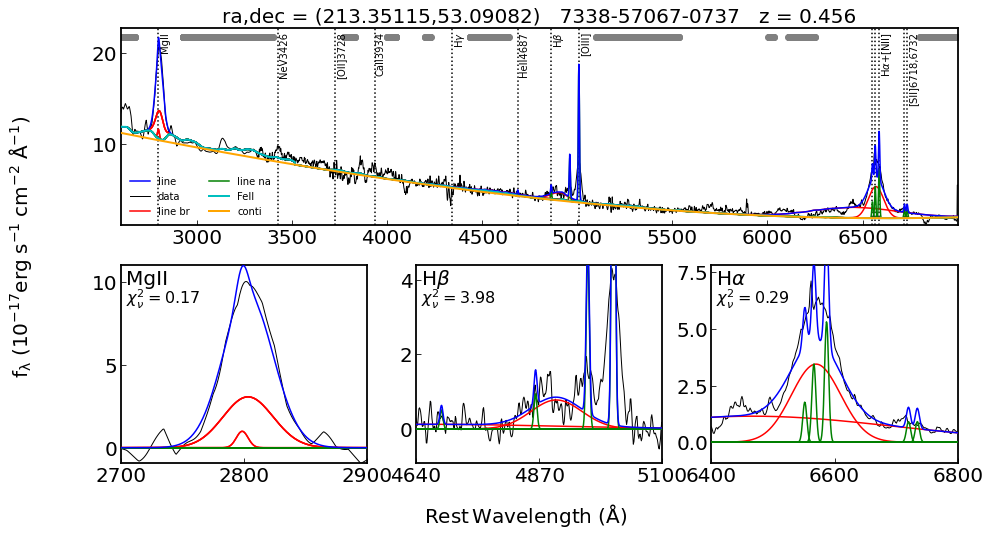

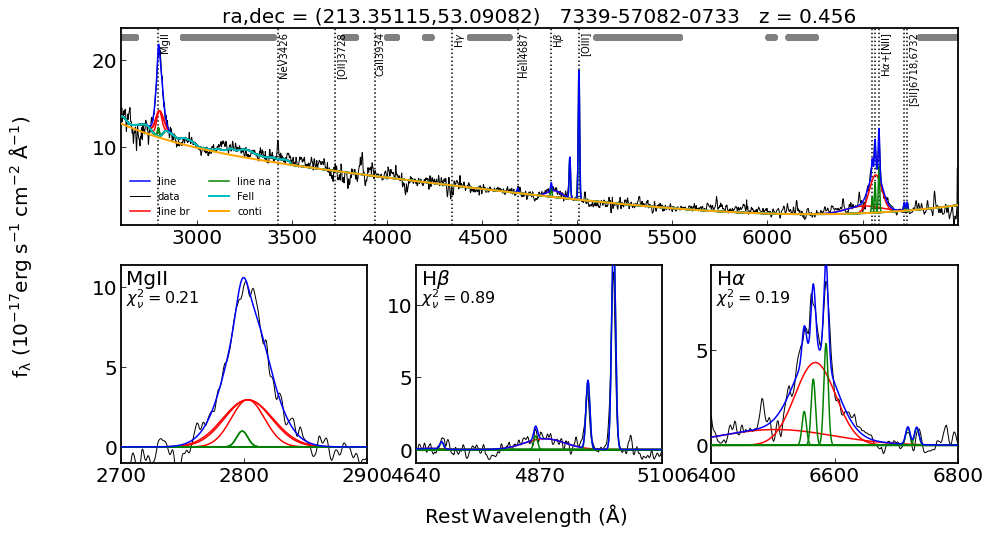

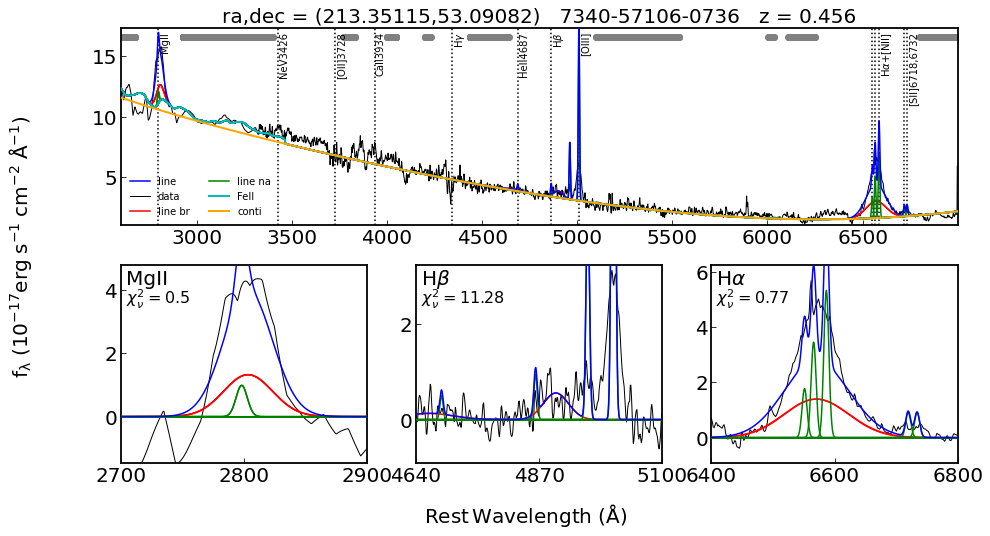

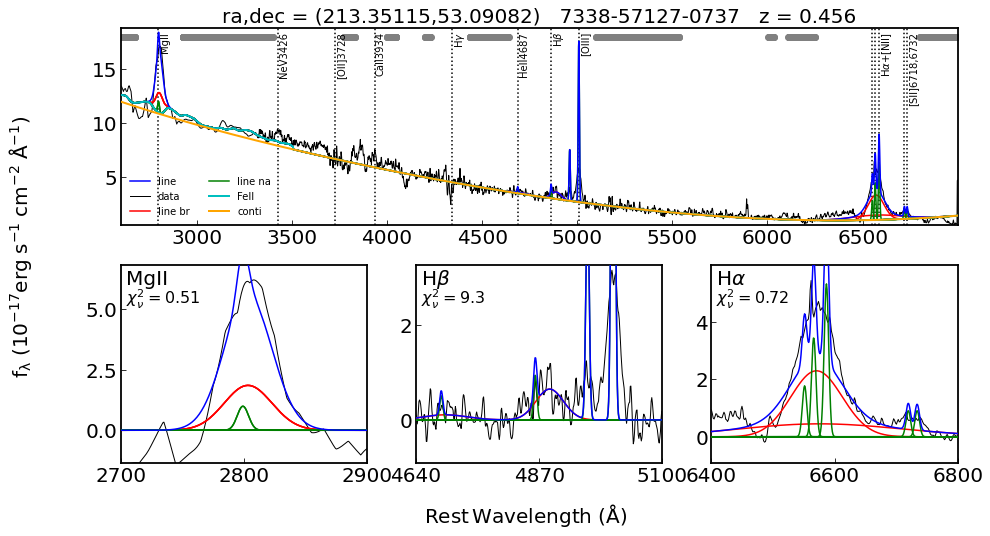

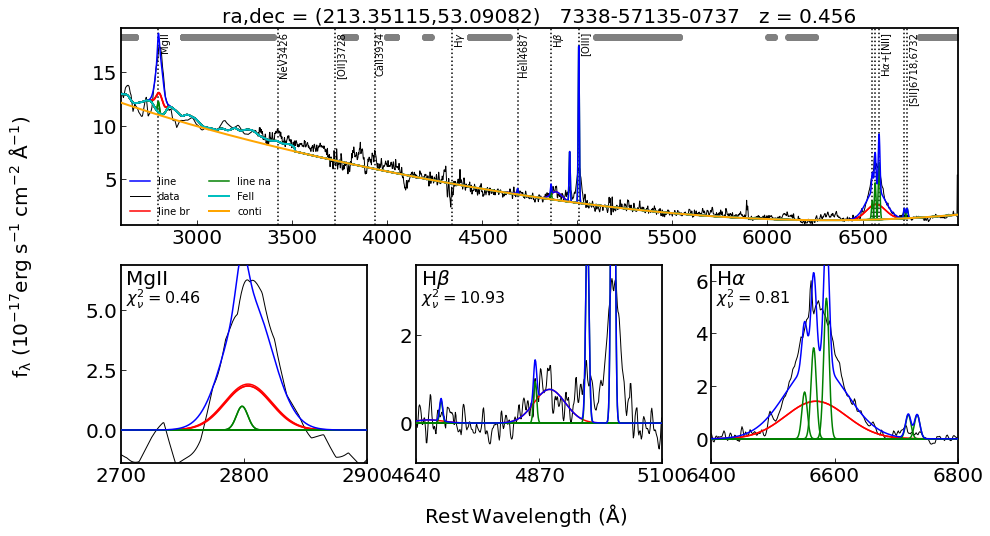

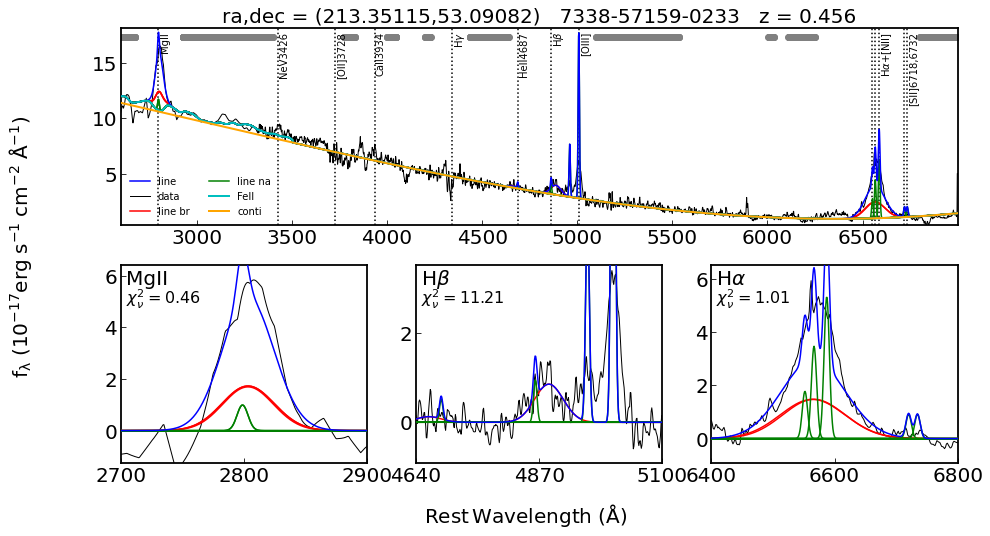

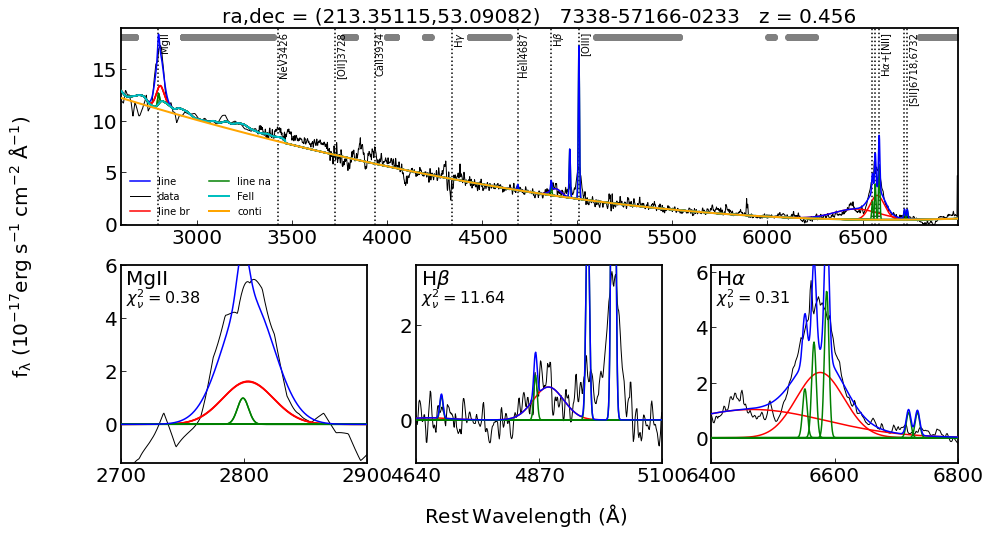

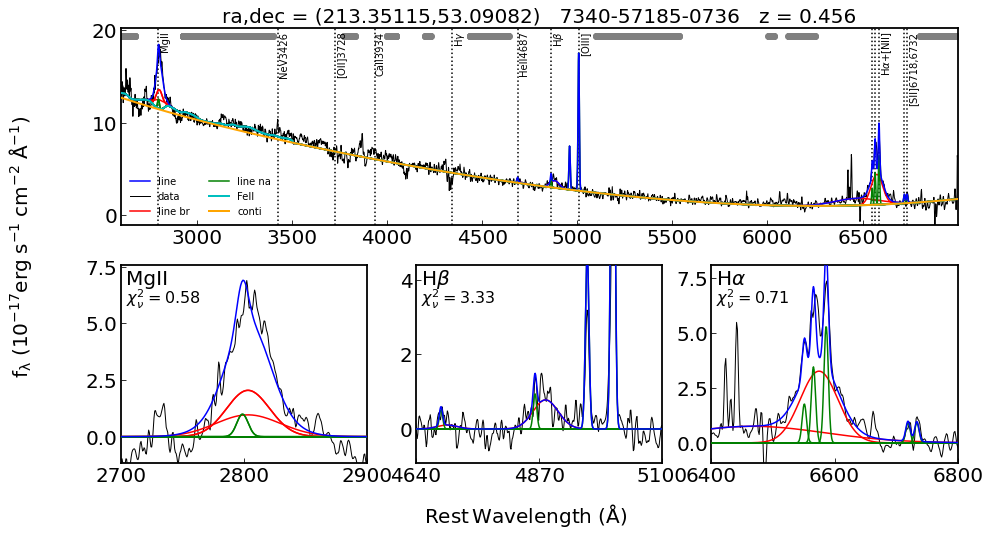

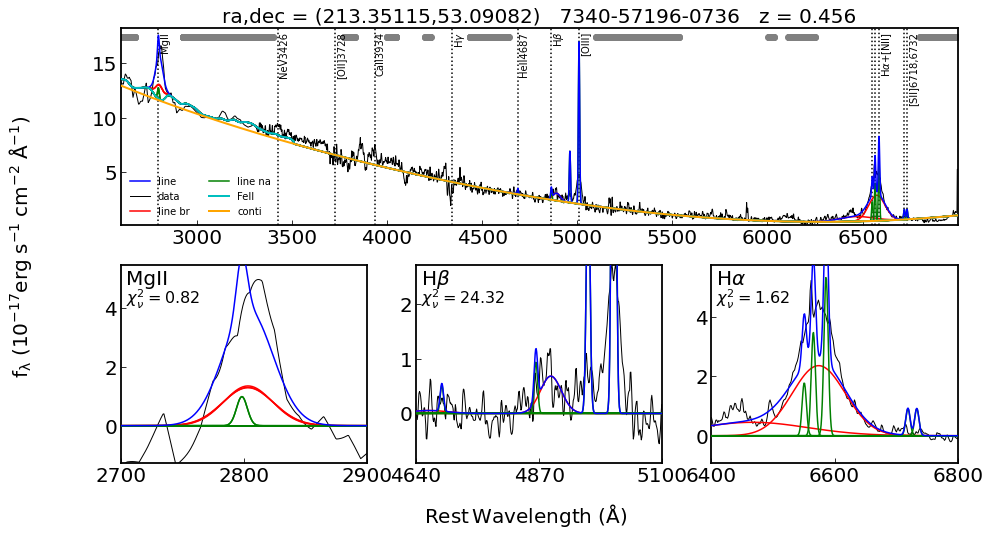

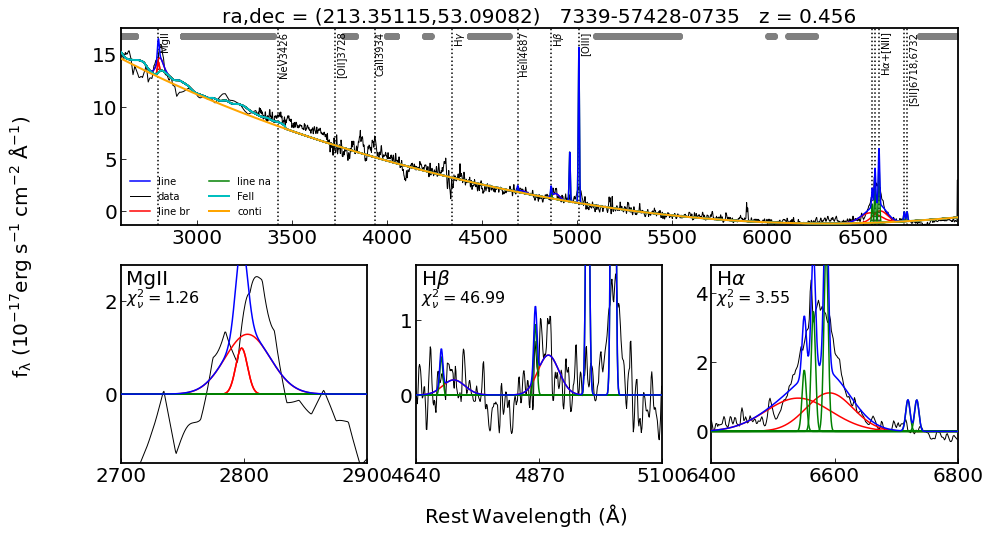

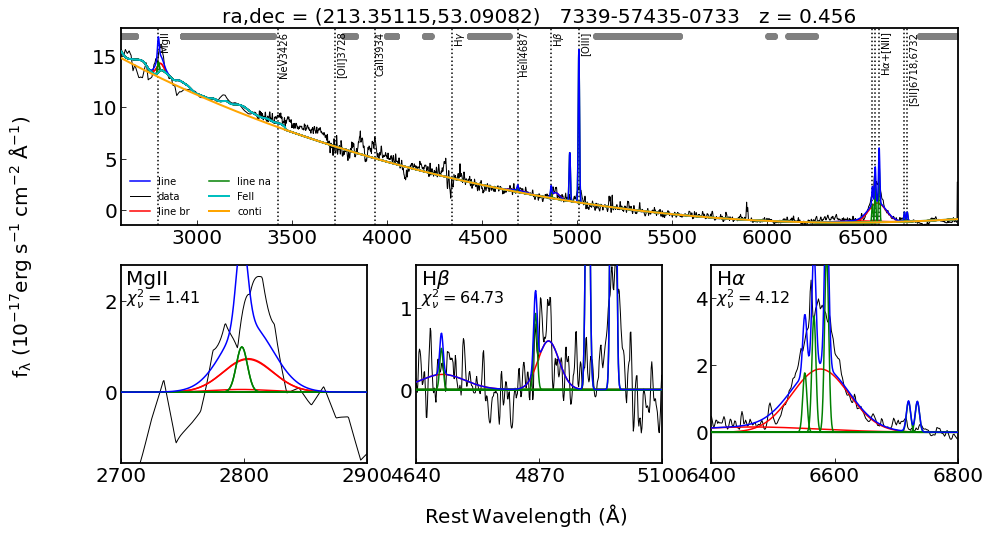

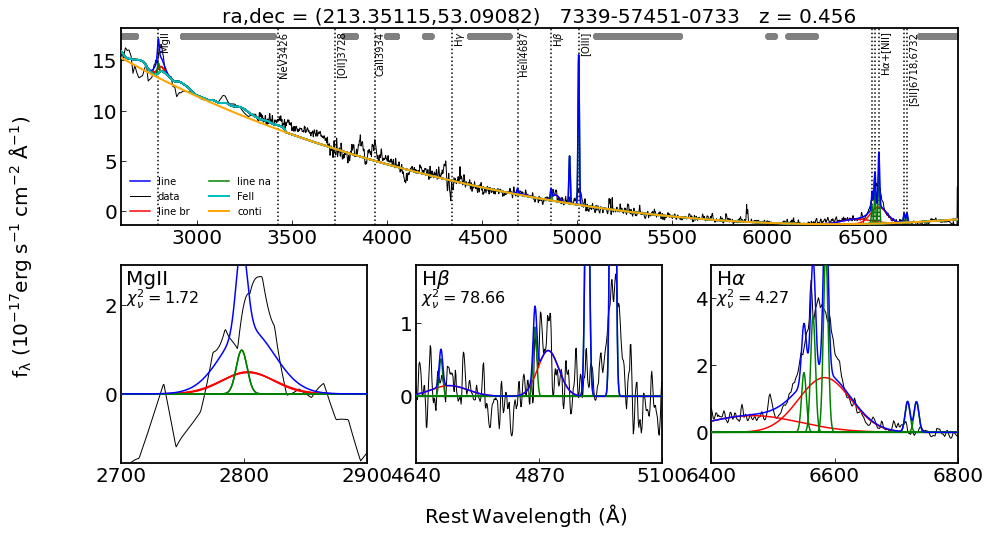

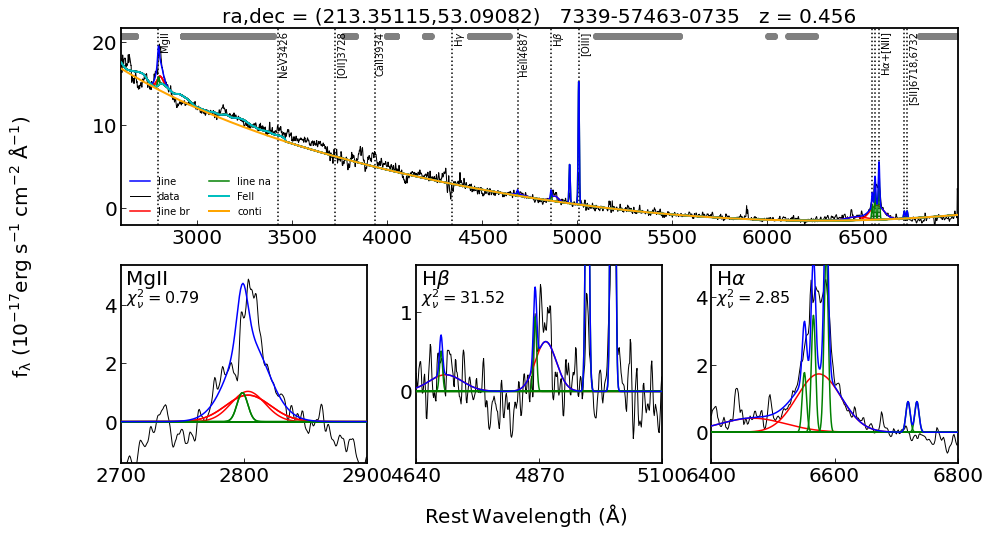

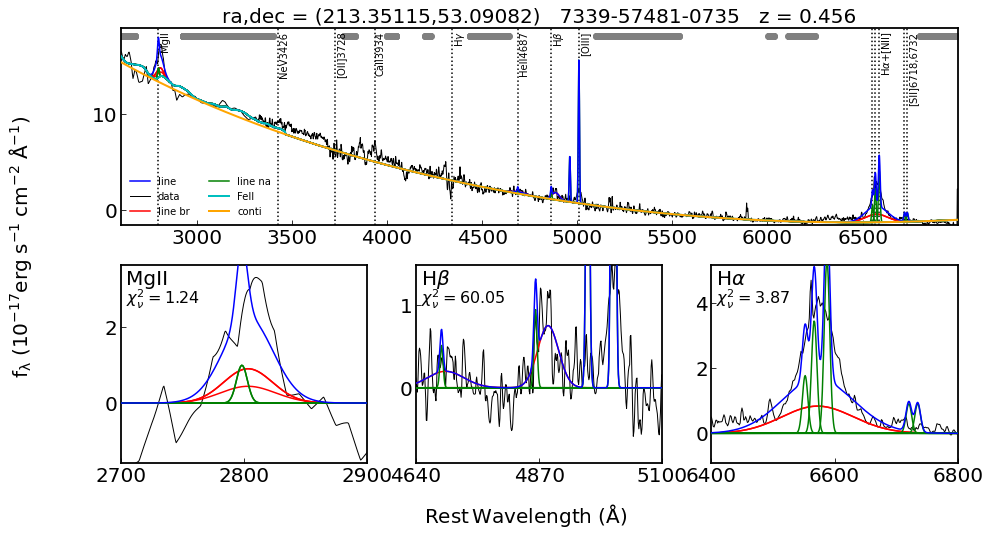

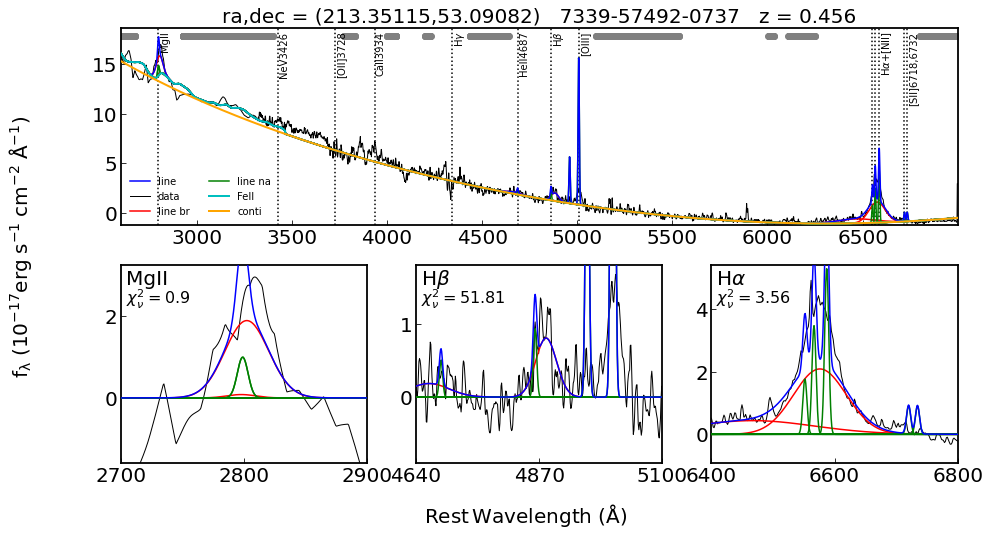

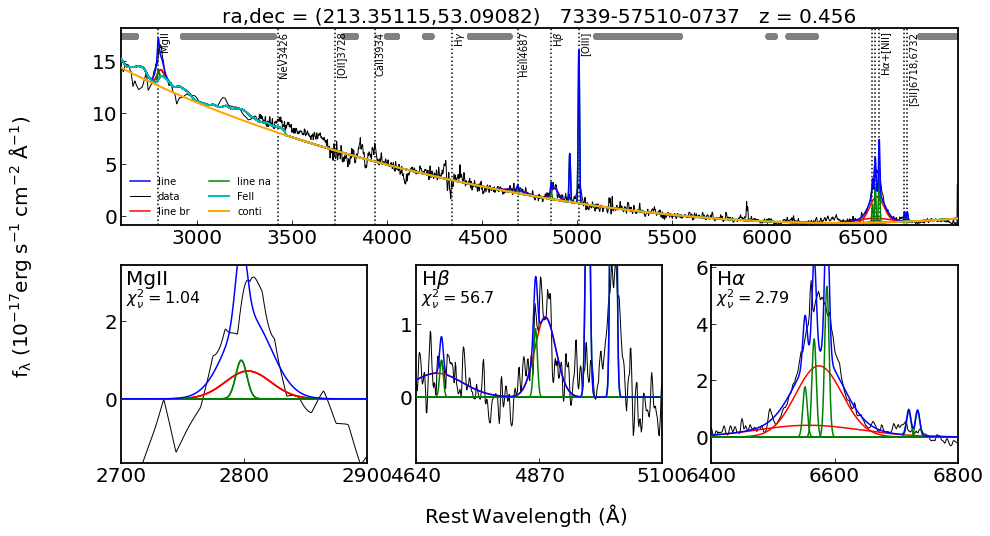

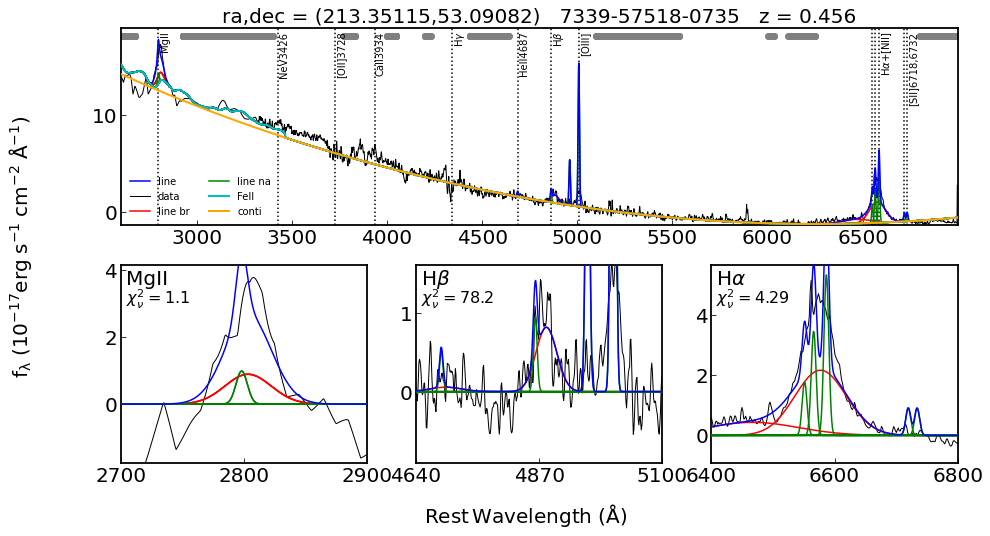

In [94]:
start = timeit.default_timer()
res = np.zeros([0, q0.all_result.shape[0]])
spec, error, line, BL = [np.zeros([0, q0.wave.shape[0]])]*4

#spectra_file_names = glob.glob(os.path.join(path_ex, 'spec-*.fits'))

spec_all_calibrated = fits.open(os.path.join(path_ex, 'table.fits'))


# Save as single PDF
with bpdf.PdfPages(path_ex + 'all.pdf') as pdf:
    
    # For each spectrum
    for i in range(len(spectra_file_names)):
        
        plate = spec_all_calibrated[1].data['plate'][i]
        mjd = spec_all_calibrated[1].data['mjd'][i]
        fiber = spec_all_calibrated[1].data['fiber'][i]
        ra = spec_all_calibrated[1].header['ra']
        dec = spec_all_calibrated[1].header['dec']
        
        lam = lam_RF*(1 + z)
        flux = spec_all_calibrated[3].data[i,:]
        err = spec_all_calibrated[4].data[i,:]
        
        f = interpolate.interp1d(q0.wave*(1 + z), q0.host, bounds_error=False, fill_value=0)
        host_interp = f(lam)
        
        flux = flux - host_interp
        
        q = QSOFit(lam, flux, err, z, ra=ra, dec=dec, plateid=plate, mjd=mjd, fiberid=fiber,  path=path_ex)
        
        # Do the fitting
        q.Fit(param_file_name='qsopar2.fits', name=None, nsmooth=1, and_or_mask=False, deredden=True, reject_badpix=False, wave_range=wave_range,
              wave_mask=None, decomposition_host=False, BC03=True, Mi=None, host_line_mask=False, npca_gal=10, npca_qso=5,
              Fe_uv_op=True, poly=True, BC=False, rej_abs=False, MC=False, nsamp=200, initial_guess=None, n_pix_min_host=np.inf,
              linefit=True, save_result=True, plot_fig=True, save_fig=False, plot_line_name=True, plot_legend=True)
        
        # Get the broad-line flux without the broad HeII
        indheii = np.where(q.all_result_name == 'HeII4687_br_1_scale')[0][0]
        heii_flux = q.Onegauss(np.log(q.wave), q.all_result[indheii:indheii+3].astype(np.float))
        
        # Interpolate
        interp_flux = interpolate.interp1d(q.wave, q.flux, bounds_error=False, fill_value=0)
        interp_err = interpolate.interp1d(q.wave, q.flux, bounds_error=False, fill_value=0)
        interp_line_flux = interpolate.interp1d(q.wave, q.flux, bounds_error=False, fill_value=0)
        interp_BL =  interpolate.interp1d(q.wave, q.line_flux - q.f_line_narrow_model - heii_flux, bounds_error=False, fill_value=0)
        
        # One of the spectra is missing Ha, just skip it for now!
        if q.all_result.shape[0] != q0.all_result.shape[0]:
            continue
        
        # Stack the results into 1 file
        res = np.vstack((res, q.all_result))
        spec = np.vstack((spec, interp_flux(q0.wave)))
        error = np.vstack((error, interp_err(q0.wave)))
        line = np.vstack((line, interp_line_flux(q0.wave)))
        BL = np.vstack((BL, interp_BL(q0.wave)))
        
        pdf.savefig(q.fig)
        
end = timeit.default_timer()
print('finshed in '+str(round(end-start))+'s')

In [36]:
t = Table(res, names = (q.all_result_name))

file_name = os.path.join(path_ex, 'MESFit_results.fits')
print(file_name)

t.write(file_name, format='fits', overwrite=True)

for j in ['SPEC','Line','BLflux','Err']:
    hdr2 = fits.Header()
    hdr2['EXTNAME'] = j
    hdr2['COEEF0'] = (np.log10(3600.), 'Central wavelength (log10) of first pixel')
    hdr2['COEEF1'] = (0.0001 , 'Log10 dispersion per pixel')
    hdr2['NPIXEL'] = (4650 , 'Pixel number of wavelength')
    if j == 'SPEC':
        hdr2['flux'] = ('flux', 'rest AGN flux with/without deredden and dehost, erg/s/cm^2/A')
        fits.append(filename=file_name, data=spec, header=hdr2)
    if j == 'Line':
        hdr2['lineflux'] = ('lineflux', 'Broad line + Narrow line, erg/s/cm^2/A')
        fits.append(filename=file_name, data=line, header=hdr2)
    if j == 'BLflux':
        hdr2['BLflux'] = ('BLflux','line flux - narrow line model, erg/s/cm^2/A')
        fits.append(filename=file_name, data=BL, header=hdr2)
    if j == 'Err':
        hdr2['err'] = ('err','spec err, erg/s/cm^2/A')
        fits.append(filename=file_name, data=error, header=hdr2)

### 6.1 plot the continuum and emission line light curves

In [37]:
d=fits.open(file_name)[1].data
norm = fits.open('/Users/legolason/study/mesfit/test/data/QA_RM017/table.fits')[1].data

mjd = m.s2f(d['mjd'])
l5100 = m.s2f(d['L5100'])
l3000 = m.s2f(d['L3000'])


plt.figure(figsize=(15,15))
plt.subplot(411)
L3000=np.log10(10**np.array(l3000)+m.flux2L(norm['shift'][1:]*3000.,z))
L5100=np.log10(10**np.array(l5100)+m.flux2L(norm['shift'][1:]*5100.,z))

plt.plot(mjd,L3000, 'go-',label='L3000')
plt.plot(mjd,L5100, 'bo-',label='L5100')
plt.legend(loc='best')
plt.ylabel(r'$\rm L_{\rm con}\ (erg\ s^{-1})$')

plt.subplot(412)
plt.plot(mjd,np.log10(m.flux2L(np.log10(m.s2f(d['Hb_whole_br_area'])),z)),'o-',label='Hb')
plt.plot(mjd,np.log10(m.flux2L(np.log10(m.s2f(d['Ha_whole_br_area'])),z)),'o-',label='Ha')
plt.plot(mjd,np.log10(m.flux2L(np.log10(m.s2f(d['MgII_whole_br_area'])),z)),'o-',label='MgII')
plt.ylabel(r'$\rm L_{\rm line}\ (erg\ s^{-1})$')

plt.legend(loc='best')

plt.subplot(413)
plt.plot(mjd, norm['factor'][1:],'o-',label='Norm factor')
plt.plot(mjd, norm['shift'][1:],'o-',label='Shift')
plt.plot(mjd, norm['sigma'][1:],'o-',label='sigma')
plt.legend(loc='best')
plt.ylabel(r'$\rm Shift\ (\AA)/ Sigma\ (\AA) /Factor$')

plt.subplot(414)
plt.plot(mjd,m.s2f(d['1_line_red_chi2']), 'o-',label=d['1_complex_name'][0])
plt.plot(mjd,m.s2f(d['2_line_red_chi2']), 'o-',label=d['2_complex_name'][0])
plt.plot(mjd,m.s2f(d['3_line_red_chi2']), 'o-',label=d['3_complex_name'][0])
plt.plot([56200,57600],[1,1],'k--')
plt.legend(loc='best')
plt.ylabel(r'$\rm Reduced\ \chi^2$')
plt.xlabel(r'$\rm MJD$')

NameError: name 'path1' is not defined

### 6.2 plot the correlations between different parameters

In [ ]:
plt.figure(figsize=(21,5))

plt.subplot(131)
plt.plot(L5100,np.log10(m.s2f(d['Hb_whole_br_area'])), 'o',label='Hb')
plt.plot(L5100,np.log10(m.s2f(d['Ha_whole_br_area'])), 'o',label='Ha')
plt.plot(L5100,np.log10(m.s2f(d['MgII_whole_br_area'])), 'o',label='MgII')
plt.xlabel(r'$\rm L_{con}\ (erg\ s^{-1})$')
plt.ylabel(r'$\rm Log\ L_{line} (erg\ s^{-1})$')
plt.xlim(43.,45)
plt.legend(loc='best',framealpha=0.5)

plt.subplot(132)
plt.plot(L5100,np.log10(m.s2f(d['Hb_whole_br_sigma'])), 'o',label='Hb')
plt.plot(L5100,np.log10(m.s2f(d['Ha_whole_br_sigma'])), 'o',label='Ha')
plt.plot(L5100,np.log10(m.s2f(d['MgII_whole_br_sigma'])), 'o',label='MgII')
plt.xlabel(r'$\rm L_{con}\ (erg\ s^{-1})$')
plt.ylabel(r'$\rm Log\ \sigma\ (km\ s^{-1})$')
plt.xlim(43.,45)
plt.plot([43,45],[3.7,3.2],'k')

plt.subplot(133)
plt.plot(L5100,np.log10(m.s2f(d['Hb_whole_br_ew'])), 'o')
plt.plot(L5100,np.log10(m.s2f(d['Ha_whole_br_ew'])), 'o')
plt.plot(L5100,np.log10(m.s2f(d['MgII_whole_br_ew'])), 'o')
plt.xlabel(r'$\rm L_{con}\ (erg\ s^{-1})$')
plt.ylabel(r'$\rm Log\ EW (\AA)$')
plt.xlim(43.,45)



### 6.3 plot the radial velocity shift of different lines

In [ ]:
mesfit=fits.open('./test/data/QA_RM017/MESFit_results.fits')
bl=mesfit[4].data
err=mesfit[5].data
spec=mesfit[2].data
shift_hb=np.array([])
shift_oiii=np.array([])
shift_ha=np.array([])
shift_mgii=np.array([])
SNline = np.array([])
mjd=mesfit[1].data['mjd']


for i in range(bl.shape[0]):
    # calculate hb SN
    SN = m.CalLineSN(m.mean_wv,spec[i,:],line_min = 4800, line_max=4950,conti = 5100)
    SNline = np.hstack((SNline,SN))

    shift,chi2_min,left,right = m.corr(m.mean_wv, spec[i,:],err[i,:], m.mean_wv,spec[-1,:],
     err[-1,:],wv_min=4980,wv_max=5050,plot = False)
    shift_oiii = np.hstack((shift_oiii,shift))
    
    shift,chi2_min,left,right = m.corr(m.mean_wv, bl[i,:],err[i,:], m.mean_wv,bl[35,:],
     err[35,:],wv_min=4800,wv_max=4950, plot = True)
    shift_hb = np.hstack((shift_hb,shift))
    
    shift,chi2_min,left,right = m.corr(m.mean_wv, bl[i,:],err[i,:], m.mean_wv,bl[35,:],
     err[35,:],wv_min=6450,wv_max=6650, plot = True)
    shift_ha = np.hstack((shift_ha,shift))
    
    shift,chi2_min,left,right = m.corr(m.mean_wv, bl[i,:],err[i,:], m.mean_wv,bl[35,:],
     err[35,:],wv_min=2750,wv_max=2850, plot = True)
    shift_mgii = np.hstack((shift_mgii,shift))
        


In [ ]:
#plt.plot(m.s2f(mjd),SNline*20,'ko')
#indsn = np.where( (SNline > 10) & (L5100 > 44.2),True,False)
plt.figure(figsize=(12,10))
plt.subplot(311)
plt.plot(m.s2f(mjd),shift_hb*69,'bo',label='Hb')
plt.plot(m.s2f(mjd),shift_oiii*69,'ro',label='[OIII]')
plt.legend(fontsize=15,loc='best')
plt.subplot(312)
plt.plot(m.s2f(mjd),shift_oiii*69,'ro',label='[OIII]')
plt.plot(m.s2f(mjd),shift_ha*69,'gs',label='Ha')
plt.ylim(-400,400)
plt.legend(fontsize=15,loc='best')
plt.ylabel(r'$\rm RV\ (km\ s^{-1})$')
plt.subplot(313)
plt.plot(m.s2f(mjd),shift_mgii*69,'m^',label='MgII')
plt.plot(m.s2f(mjd),shift_oiii*69,'ro',label='[OIII]')
plt.xlabel(r'$\rm MJD$')
plt.legend(fontsize=15,loc='best')

In [ ]:
flux_all = np.zeros_like(m.mean_wv)
c= 0
for i in range(bl.shape[0]):
    c=c+1
    #plt.plot(m.mean_wv, spec[i,:])
    flux_all = flux_all+(bl[i,:]-BL_mean)**2
fig=plt.figure(figsize=(21,5))
plt.errorbar(m.mean_wv,np.sqrt(flux_all)/c,yerr=m.rms_err,color='gray',elinewidth=0.,capthick=0,capsize=0,alpha=0.1)

rms2_spec=np.sqrt(flux_all)/c

plt.subplot(131)

plt.plot(m.mean_wv,rms2_spec)
plt.xlim(2700,2900)
plt.ylim(-0.,1)
plt.ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)')
plt.title(r'$\rm MgII\ RMS$')
ind=np.where( (m.mean_wv < 2830) & (m.mean_wv>2770),True,False )
plt.plot(m.mean_wv[ind],rms2_spec[ind],'r')
fwhm, sigma = m.Calwidth(m.mean_wv,rms2_spec, wv_min = 2760,wv_max=2830)
plt.text(2720,0.9,r'$\sigma$ = '+ str(sigma)+r'$\rm \ km\ s^{-1}$', fontsize =20)
#plt.plot(m.mean_wv,(m.rms_spec-1)*1.8)

plt.subplot(132)
plt.plot(m.mean_wv,rms2_spec)
plt.xlim(4700,5000)
plt.ylim(-0.0,.4)
plt.title(r'$\rm H\beta\ RMS$')
ind=np.where( (m.mean_wv < 4930) & (m.mean_wv>4820),True,False )
plt.plot(m.mean_wv[ind],rms2_spec[ind],'r')
fwhm, sigma = m.Calwidth(m.mean_wv,rms2_spec, wv_min = 4820,wv_max=4930)
plt.text(4720,0.35,r'$\sigma$ = '+ str(sigma)+r'$\rm \ km\ s^{-1}$', fontsize =20)
#plt.plot(m.mean_wv,(m.rms_spec-0.22)*1.8)
print fwhm,sigma

plt.subplot(133)

plt.plot(m.mean_wv,rms2_spec)
plt.xlim(6400,6700)
plt.ylim(-0.,1)
plt.title(r'$\rm H\alpha\ RMS$')
ind=np.where( (m.mean_wv < 6630) & (m.mean_wv>6515),True,False )
plt.plot(m.mean_wv[ind],rms2_spec[ind],'r')
fwhm, sigma = m.Calwidth(m.mean_wv,rms2_spec, wv_min = 6515,wv_max=6630)
plt.text(6500,0.9,r'$\sigma$ = '+ str(sigma)+r'$\rm \ km\ s^{-1}$', fontsize =20)
#plt.plot(m.mean_wv,(m.rms_spec-0.1)*1.5)
